***

### **چرا قیمت‌ها صفر هستند؟**

در این تاریخ‌ها بازارهای مالی بریتانیا (UK) تعطیل بوده‌اند و هیچ معامله‌ای انجام نشده، بنابراین قیمت‌ها به صورت 0.0 ثبت شده‌اند.

#### **کریسمس (تعطیلات پایان سال)**

بازارهای بریتانیا در دوره کریسمس معمولاً چند روز بسته هستند:

- 2009-12-24 تا 2009-12-31

- 2010-12-24 تا 2010-12-31

#### **روز سال نو**

- 2010-01-01

- 2011-01-03 (تعطیلی جایگزین برای New Year’s Day)

#### **تعطیلات عید پاک (Easter Holidays)**

این تعطیلات شامل دو روز رسمی است:
Good Friday و Easter Monday

- 2010-04-02 (جمعه نیک – Good Friday)

- 2010-04-05 (دوشنبه عید پاک – Easter Monday)

- 2011-04-22 (جمعه نیک)

- 2011-04-25 (دوشنبه عید پاک)

#### **Early May Bank Holiday**

یک تعطیلی رسمی که اولین دوشنبه ماه می برگزار می‌شود:

- 2010-05-03

- 2011-05-02

#### **Spring Bank Holiday**

یک تعطیلی رسمی که آخرین دوشنبه ماه می برگزار می‌شود:

- 2010-05-31

- 2011-05-30

#### **Summer Bank Holiday**

یک تعطیلی رسمی که آخرین دوشنبه ماه آگوست برگزار می‌شود:

- 2010-08-30

- 2011-08-29

#### **عروسی سلطنتی**

در این روز شاهزاده ویلیام و کاترین میدلتون ازدواج کردند و دولت بریتانیا این روز را تعطیل رسمی ملی اعلام کرد
- 2011-04-29

***

# ساختار داده ها
- Country: کشورهای که فروش در آنجا انجام شده به دلیل اینکه انگلیس اکثر داده  ما را تشکیل می داد از بقیه کشورها صرف نظر شد و به تحلیل فقط میزان فروش در انگلیس پرداخته شد.
- Customer ID : یک کد مختص به یک مشتری
- **Price**: قیمت هر واحد از کالا
- **Quantity**:‌ تعداد خرید مشتری از یک نوع کالا
- Description: توضیح راجب کالا
- StockCode:‌ کد مختص به سهام کالا
- Invoice: شماره خرید
- **InvoiceDate**: زمان خرید
- **Holiday:** نشان دادن اینکه در آن روز به خصوص آیا تعطیل هست یا خیر

In [46]:
#وارد کردن کتابخانه های مورد نیاز

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import seasonal_plot , month_plot,quarter_plot , plot_acf,plot_pacf # نمودارهای خودهمبستگی و خودهمبستگی جزئی
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima , model_selection , ARIMA
from sklearn.metrics import mean_absolute_percentage_error , mean_squared_error , mean_absolute_error , root_mean_squared_error
from sklearn.model_selection import ParameterGrid , TimeSeriesSplit
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import Ridge
from scipy.stats import boxcox


from statsmodels.sandbox.stats.runs import runstest_1samp # تست رانز-تست
from statsmodels.stats.diagnostic import kstest_normal # تست کولموگروف-اسمیرنوف
from statsmodels.tsa.stattools import kpss


import warnings
warnings.filterwarnings("ignore", message=".*force_all_finite.*")
import warnings
warnings.filterwarnings("ignore")
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
df = pd.read_csv('df_comb' , parse_dates=True , index_col='InvoiceDate')

## پیش پردازش داده ها

In [4]:
df.drop('Unnamed: 0' , axis=1 , inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1067371 entries, 2009-12-01 07:45:00 to 2011-12-09 12:50:00
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   Price        1067371 non-null  float64
 5   Customer ID  824364 non-null   float64
 6   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [6]:
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [7]:
# # prepare the customer dataset
# df = df.reset_index()
# customer_data = df.copy()
# customer_data.dropna(subset = ['Customer ID'], inplace=True) # drop all rows with null customer ID
# customer_data['Invoice'] = customer_data['Invoice'].astype(str) # set Invoice dtype to string
# customer_data['Customer ID'] = customer_data['Customer ID'].astype(int) # set customer ID column to int
# # create TotalValue column = Price * Quantity
# customer_data['TotalValue'] = customer_data['Quantity'] * customer_data['Price']

# # monetary value
# monetary = customer_data[['Customer ID','TotalValue']].groupby('Customer ID').agg(Monetary = ('TotalValue', 'sum'))

# # to compute number of orders and last order date --> extra filters to keep only positive orders
# positive_orders = customer_data.copy()
# positive_orders = positive_orders[(~positive_orders['Invoice'].str.contains('C', na = False))] # remove cancellations
# positive_orders = positive_orders[(~positive_orders['Invoice'].str.contains('A', na = False))] # remove accounting invoices
# # remove any other cancelled orders such as crushed items - represented negative quantity
# positive_orders = positive_orders[(positive_orders['Quantity'] >= 0)]

# # number of positive orders
# frequency = positive_orders[['Customer ID','InvoiceDate']].groupby('Customer ID').agg(Frequency = ('InvoiceDate', 'count'))
# # last positive order date
# recency = positive_orders[['Customer ID','InvoiceDate']].groupby('Customer ID').agg(Recency = ('InvoiceDate', 'max'))

# # number of customers without a positive order but with negative orders
# customers_negative_orders = monetary[~monetary.index.isin(recency.index)].index
# print('There is {} customers with only negative value orders and not a single postive value order'.format(len(customers_negative_orders)))

In [8]:
# print('The number of missing values in Customer ID: {} of {}, {:.1f}%'.format(
#     df['Customer ID'].isna().sum(), df.shape[0], df['Customer ID'].isna().sum() * 100 / df.shape[0]))

### تعداد داده های ناموجود در هر ستون

In [9]:
# count of missing values per column
na_summary = df.isna().sum().to_frame().sort_values(by = 0, ascending=False)
na_summary.columns = ['na_count']
# proportion of null values per column
na_summary['na_proportion'] = round(na_summary['na_count'] * 100 / df.shape[0],2)
na_summary

,na_count,na_proportion
Customer ID,243007,22.77
Description,4382,0.41
Invoice,0,0.00
StockCode,0,0.00
Quantity,0,0.00
Price,0,0.00
Country,0,0.00


### حذف کشورها 
همینطور که در نمودار زیر می بینیم اکثر داده های ما از کشور انگلیس میاد و کار درست این هست که فقط داده های فروش در این کشور مورد بررسی قرار بگیره

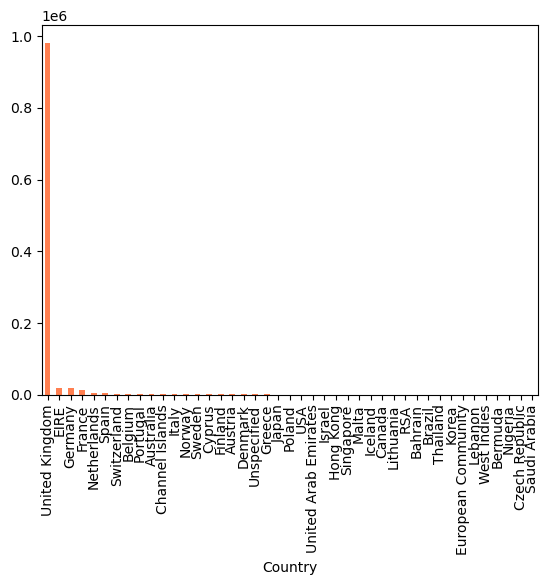

In [10]:
country_counts = df['Country'].value_counts()
fig = country_counts.plot(kind='bar', color='coral')

In [11]:
df = df[df['Country'] == 'United Kingdom']

In [12]:
df.head()

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country
InvoiceDate,,,,,,,
2009-12-01 07:45:00,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085.0,United Kingdom
2009-12-01 07:45:00,489434,79323P,PINK CHERRY LIGHTS,12,6.75,13085.0,United Kingdom
2009-12-01 07:45:00,489434,79323W,WHITE CHERRY LIGHTS,12,6.75,13085.0,United Kingdom
2009-12-01 07:45:00,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10,13085.0,United Kingdom
2009-12-01 07:45:00,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25,13085.0,United Kingdom


***

## حذف بازگشت های عجیب و غریب
در اینجا با عدد های خیلی زیادی برخورد می کنیم که نشان دهنده درستی از بازگشت کالا توسط مشتری نیست! به همین دلیل میایم و بازگشت های بالاتر از ۵۰ تا را حذف میکنیم

In [13]:
df[(df['Quantity'] < 0) & (df['Price'] > 0)]['Quantity'].unique()

array([    -3,     -2,     -6,     -1,    -12,     -4,    -24,    -81,
          -48,     -5,     -8,     -9,   -504,   -600,   -252,   -246,
          -36,    -10,    -32,    -60,    -18,    -96,    -50,    -16,
         -120,    -64,   -168,     -7,    -23,    -13,    -25,    -20,
          -11,   -100,    -17,   -144,   -190,    -72,    -30,    -14,
          -44,   -132,    -27,   -150,    -26,    -22,   -300,    -21,
          -40,   -192,   -240,    -15,   -432,   -108,    -28,    -80,
          -74,    -42,   -200,   -408,    -38,  -1440,    -34,   -288,
         -204,   -160,   -309,    -19,   -400,   -500,   -280,   -140,
         -128,   -250,   -156,  -1200,    -69,   -312,    -51,    -49,
          -41,   -830,   -210,    -98,    -99,    -29,    -61,   -576,
         -320,   -648,   -720,    -85,    -90,    -55,   -180,   -118,
         -324,    -35,    -31,    -59,   -700,  -1152,   -384,    -56,
         -148,   -270,   -243,  -2400,   -248,   -256,   -212,   -213,
      

In [14]:
df = df[df['Quantity'] > -50]

In [15]:
df = df[df['Description'] != 'Adjust bad debt']

In [16]:
df.drop_duplicates(inplace=True)

حذف فروش هایی که کنسل شده اند که با حرف C اول ستون شماره خرید قرار گرفته شده.

In [17]:
df = df[~df['Invoice'].astype(str).str.startswith('C')]

 دو ستون کمیت و قیمت دو ستون مهم برای ما هست تا با این دو ستون یک ستون جدید به نام قیمت کل بسازیم.

In [18]:
# ساختن ستون جدید به نام قیمت 
df['TotalPrice'] = df['Quantity'] * df['Price']

In [19]:
df[['Quantity' , 'Price' , 'TotalPrice']]

,Quantity,Price,TotalPrice
InvoiceDate,,,
2009-12-01 07:45:00,12,6.95,83.4
2009-12-01 07:45:00,12,6.75,81.0
2009-12-01 07:45:00,12,6.75,81.0
2009-12-01 07:45:00,48,2.10,100.8
2009-12-01 07:45:00,24,1.25,30.0
...,...,...,...
2011-12-09 12:31:00,12,1.95,23.4
2011-12-09 12:49:00,8,2.95,23.6
2011-12-09 12:49:00,24,1.25,30.0


ستون قیمت کل که به عنوان متغیر مورد بررسی در این سری زمانی انتخاب می کنیم.

---

## تغییر زمان داده ها
داده ها به صورت روزانه ، هفتگی و ماهانه در نمودار زیر قرار گرفته اند.

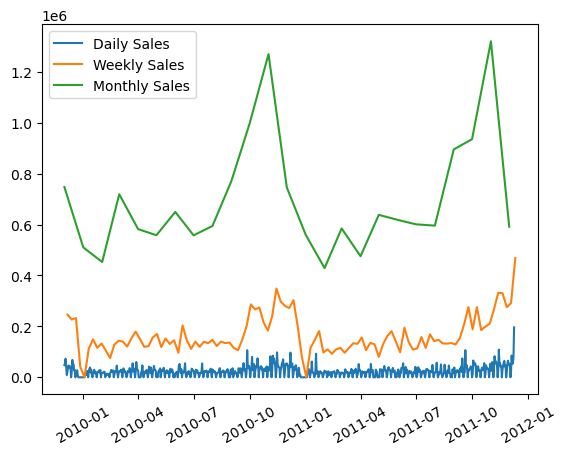

<Figure size 1000x1500 with 0 Axes>

In [20]:
daily_sales = df['TotalPrice'].resample('D').sum()
weekly_sales = df['TotalPrice'].resample('W').sum()
monthly_sales = df['TotalPrice'].resample('MS').sum()

plt.plot(daily_sales , label='Daily Sales')
plt.plot(weekly_sales , label = 'Weekly Sales')
plt.plot(monthly_sales , label = 'Monthly Sales')
plt.legend()
plt.xticks(rotation=30)
plt.figure(figsize=(10,15))
plt.show()

In [21]:
daily_sales = pd.DataFrame(daily_sales)
daily_sales = daily_sales.reset_index()

In [22]:
daily_sales

,InvoiceDate,TotalPrice
0,2009-12-01,47668.86
1,2009-12-02,55875.26
2,2009-12-03,72820.90
3,2009-12-04,37966.35
4,2009-12-05,9042.36
...,...,...
734,2011-12-05,85331.87
735,2011-12-06,52484.19
736,2011-12-07,55214.81
737,2011-12-08,78999.51


In [23]:
daily_sales = daily_sales.loc[~daily_sales['TotalPrice'].eq(0)]

In [24]:
daily_sales

,InvoiceDate,TotalPrice
0,2009-12-01,47668.86
1,2009-12-02,55875.26
2,2009-12-03,72820.90
3,2009-12-04,37966.35
4,2009-12-05,9042.36
...,...,...
734,2011-12-05,85331.87
735,2011-12-06,52484.19
736,2011-12-07,55214.81
737,2011-12-08,78999.51


***

# بررسی داده های روزانه

In [28]:
daily_sales.set_index('InvoiceDate' , inplace=True)

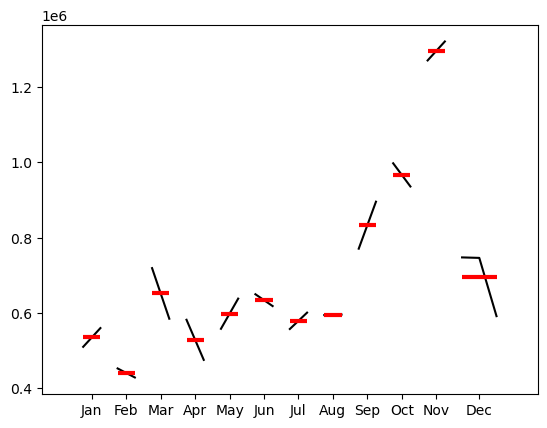

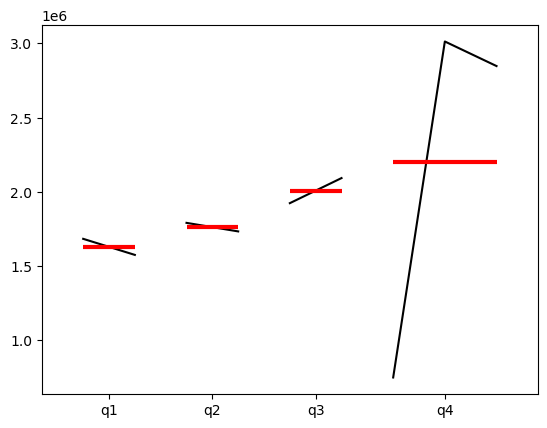

In [29]:
month_plot(daily_sales.resample('M').sum())
plt.show()
quarter_plot(daily_sales.resample('Q').sum())
plt.show()

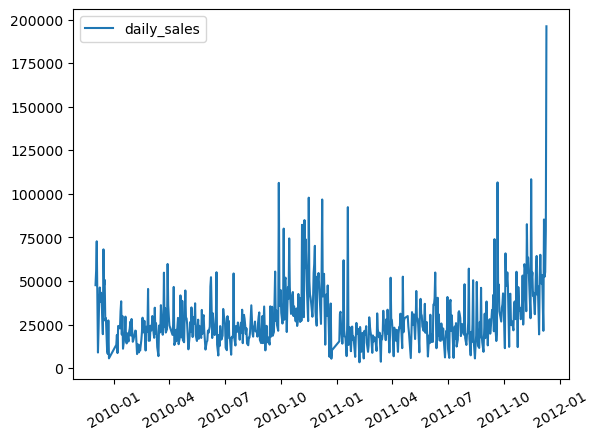

In [30]:
plt.plot(daily_sales['TotalPrice'] , label = 'daily_sales')
plt.xticks(rotation=30)
plt.legend()
plt.show()

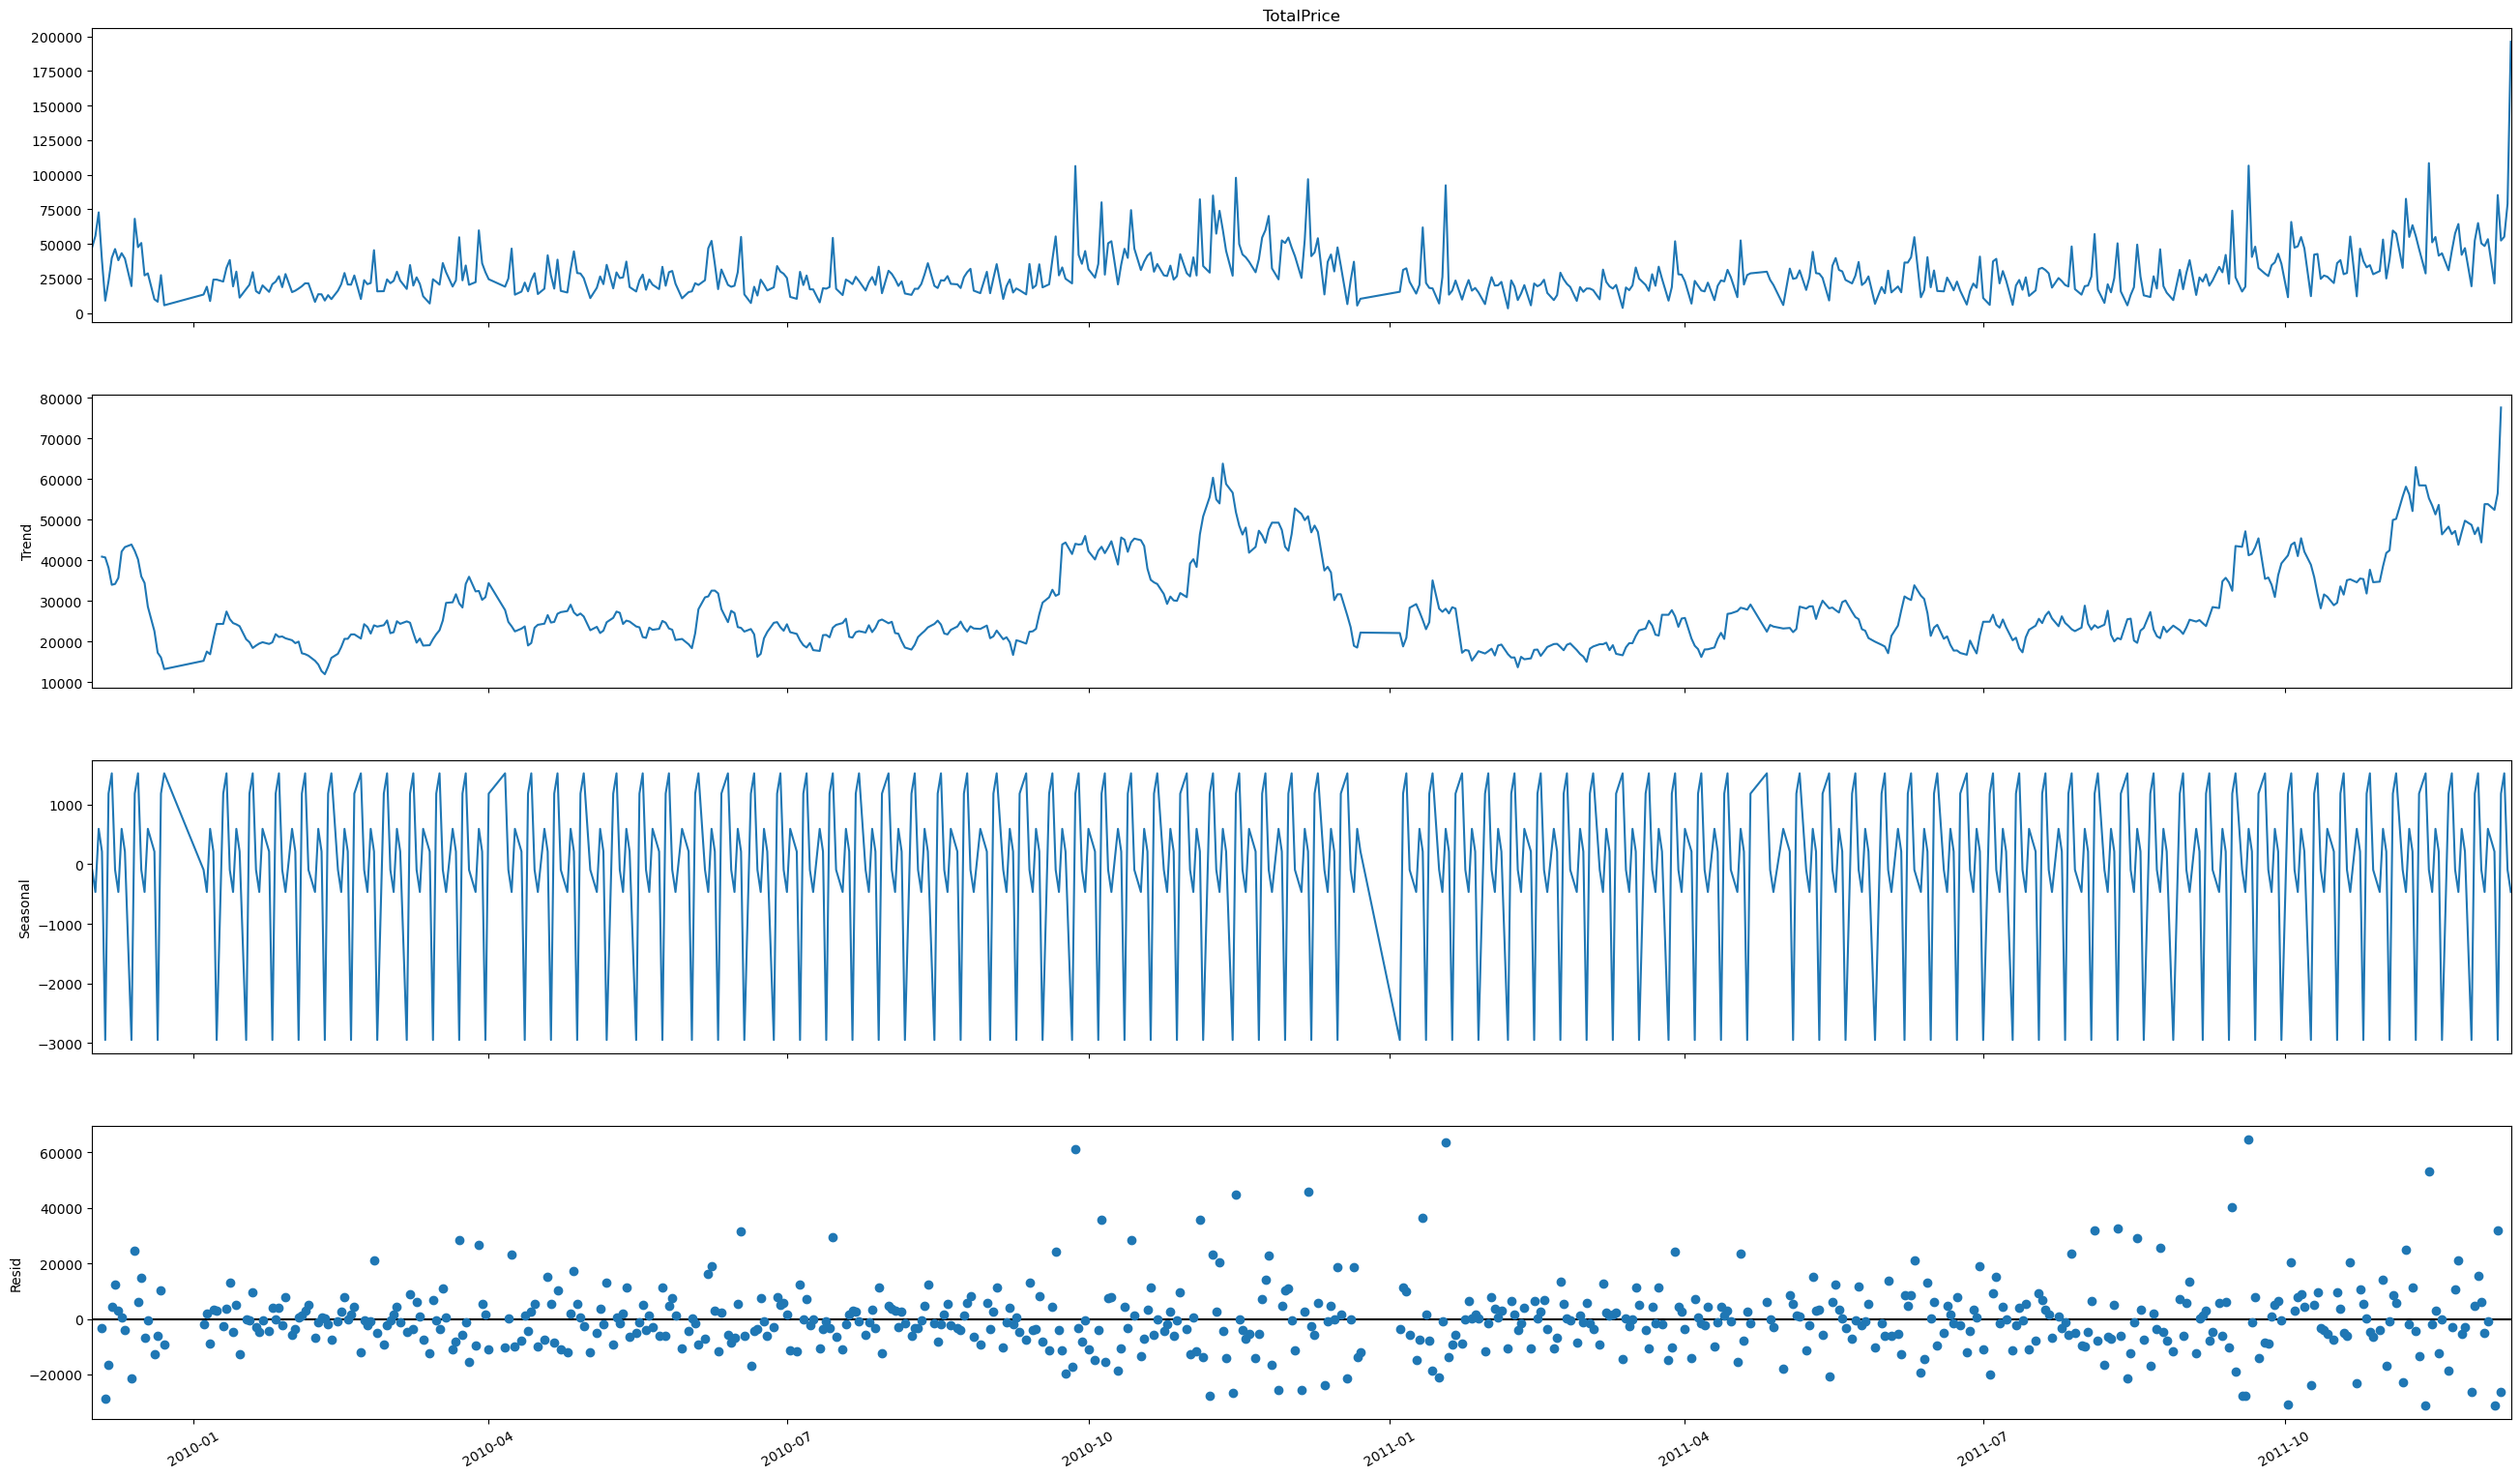

In [31]:
dec = seasonal_decompose(daily_sales['TotalPrice'] , period=7)
fig = dec.plot()
fig.set_size_inches(30,17)
plt.xticks(rotation=30)
plt.show()

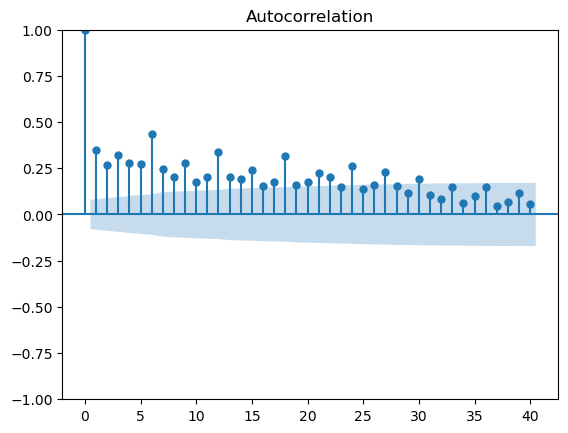

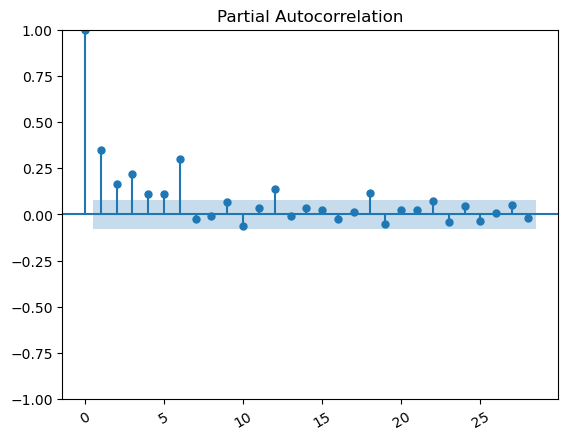

In [32]:
plot_acf(daily_sales['TotalPrice'] , lags=40) 
plot_pacf(daily_sales['TotalPrice'])
plt.xticks(rotation=30)
plt.show()

In [33]:
result = adfuller(daily_sales['TotalPrice'])
print(f'P_value : {result[1]}')
if result[1] > 0.05:
    print('تست نشان میده که داده های مانا نیستند')
else:
    print('داده ها مانا هستند')

P_value : 0.8948919984918149
تست نشان میده که داده های مانا نیستند


In [34]:
ds_ln = np.log1p(daily_sales)
ds_ln

,TotalPrice
InvoiceDate,
2009-12-01,10.772055
2009-12-02,10.930895
2009-12-03,11.195772
2009-12-04,10.544482
2009-12-05,9.109786
...,...
2011-12-05,11.354315
2011-12-06,10.868286
2011-12-07,10.919005


In [35]:
result = adfuller(ds_ln)
print(f'P_value : {result[1]}')
if result[1] > 0.05:
    print('تست نشان میده که داده های مانا نیستند')
else:
    print('داده ها مانا هستند')

P_value : 0.4751320931105454
تست نشان میده که داده های مانا نیستند


In [36]:
ds_ln_diff = ds_ln.diff(1)
ds_ln_diff.dropna(inplace=True)

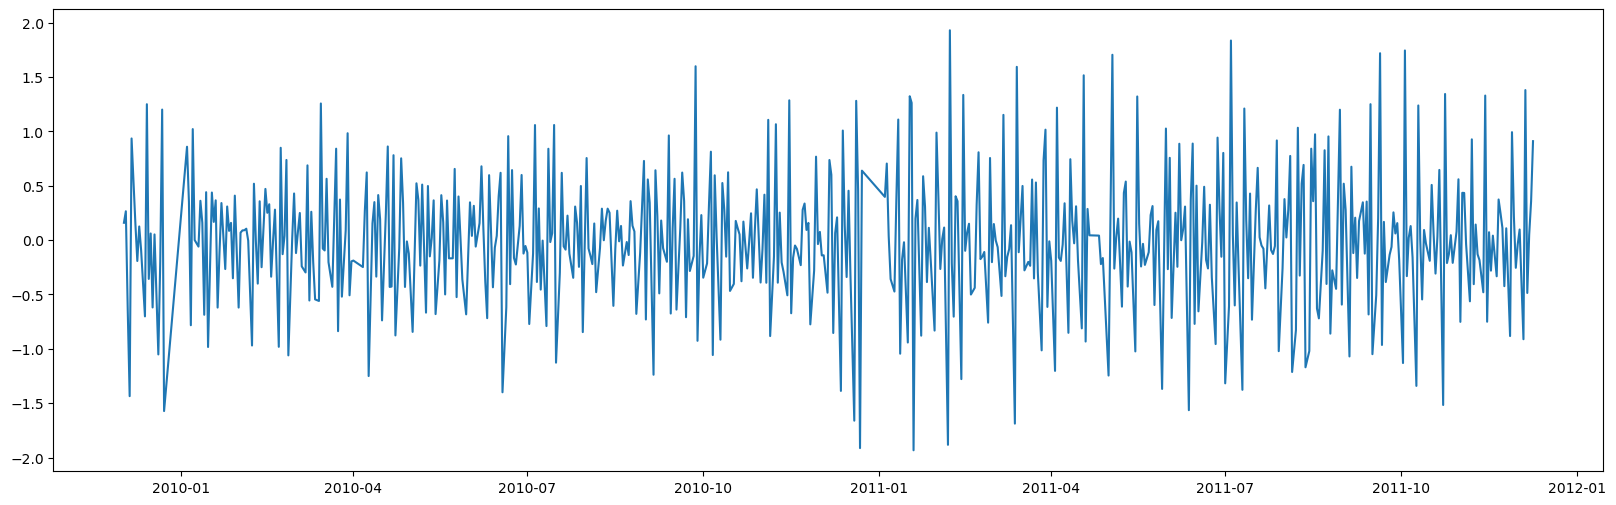

In [37]:
plt.figure(figsize=(20,6))
plt.plot(ds_ln_diff.index,ds_ln_diff)

In [38]:
result = adfuller(ds_ln_diff)
print(f'P_value : {result[1]}')
if result[1] > 0.05:
    print('تست نشان میده که داده های مانا نیستند')
else:
    print('داده ها مانا هستند')

P_value : 4.577446411956347e-16
داده ها مانا هستند


In [39]:
kpss(ds_ln_diff)

(0.24187989353131847,
 0.1,
 52,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

با توجه به دو آزمون گذشته سری زمانی ما، مانا هستند

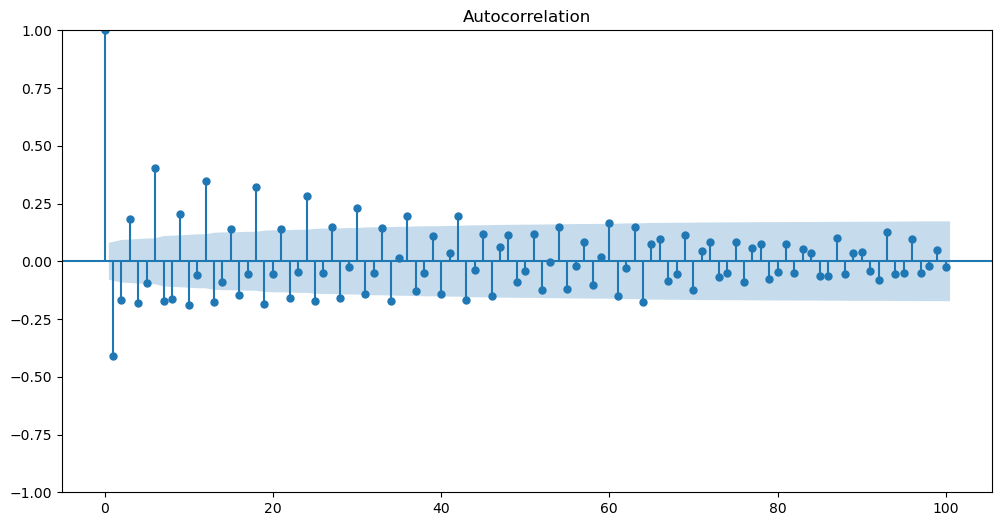

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(ds_ln_diff, lags=100, ax=ax)
plt.show()

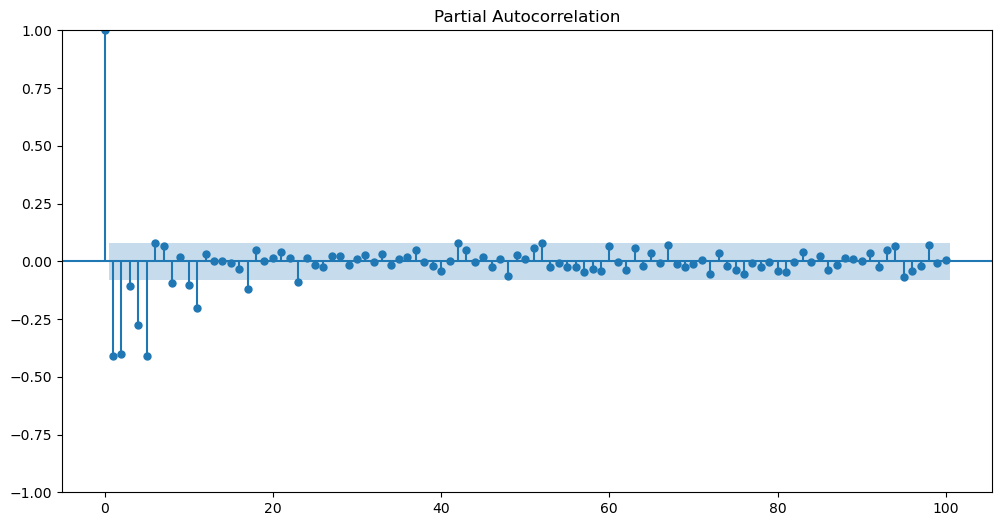

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(ds_ln_diff, lags=100, ax=ax)
plt.show()

In [42]:
train_d = ds_ln_diff.iloc[:-7]
test_d  = ds_ln_diff.iloc[-7:]

In [84]:
model = ARIMA(train_d, order=(2,0,2), seasonal_order=(1,0,1,12))
model_fit = model.fit()

In [85]:
pred_train = model_fit.predict(start=0, end=len(train_d)-1)

In [86]:
forecast = model_fit.get_forecast(steps=len(test_d))
pred_test = forecast.predicted_mean

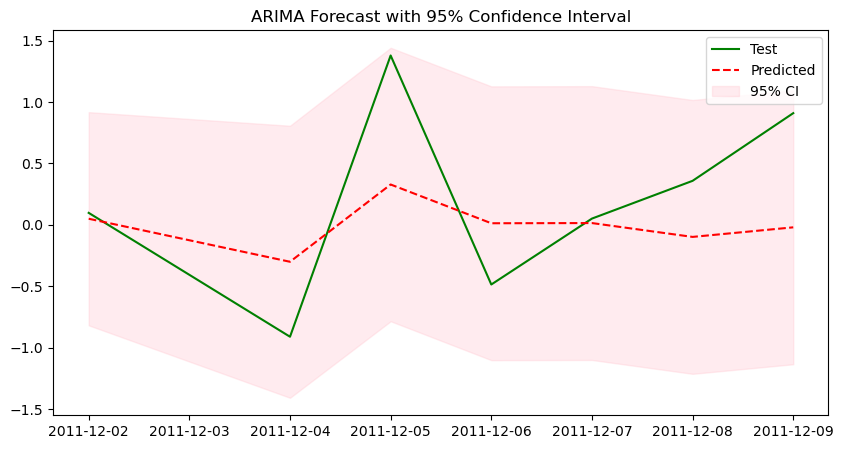

In [87]:

ci = forecast.conf_int()

# Plot
plt.figure(figsize=(10,5))
plt.plot(test_d.index, test_d, label='Test', color='green')
plt.plot(test_d.index, pred_test, label='Predicted', color='red', linestyle='--')

# Fill the area between lower and upper bounds
plt.fill_between(test_d.index,
                 ci.iloc[:, 0],   # lower bound
                 ci.iloc[:, 1],   # upper bound
                 color='pink', alpha=0.3, label='95% CI')

plt.legend()
plt.title("ARIMA Forecast with 95% Confidence Interval")
plt.show()


In [88]:
residuals = model_fit.resid

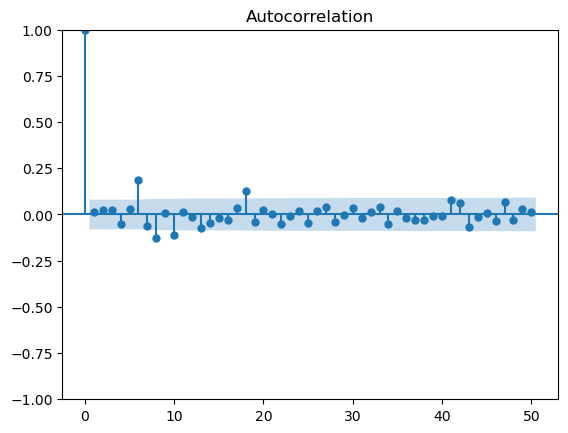

In [89]:
plot_acf(residuals, lags=50)

plt.show()

In [90]:
acorr_ljungbox(residuals)

,lb_stat,lb_pvalue
1,0.133200,0.715137
2,0.424399,0.808803
3,0.776945,0.854973
4,2.371447,0.667793
5,2.854798,0.722360
6,24.410788,0.000439
7,26.906732,0.000346
8,36.523471,0.000014
9,36.544620,0.000032
10,44.397507,0.000003


In [91]:
runstest_1samp(residuals)

(0.20393584678184795, 0.8384036320090842)

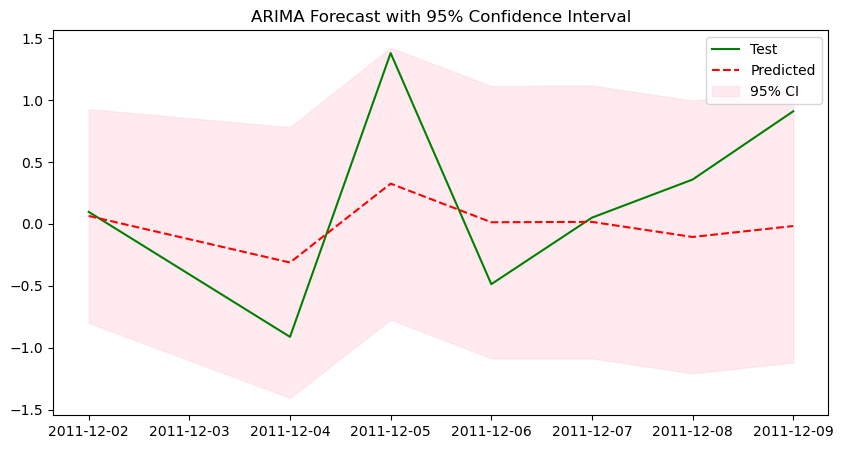

In [92]:
model_1 = ARIMA(train_d, order=(3,0,2), seasonal_order=(1,0,1,12))
model_fit_1 = model_1.fit()
pred_train = model_fit_1.predict(start=0, end=len(train_d)-1)
forecast_1 = model_fit_1.get_forecast(steps=len(test_d))
pred_test_1 = forecast_1.predicted_mean
ci = forecast_1.conf_int()

# Plot
plt.figure(figsize=(10,5))
plt.plot(test_d.index, test_d, label='Test', color='green')
plt.plot(test_d.index, pred_test_1, label='Predicted', color='red', linestyle='--')

# Fill the area between lower and upper bounds
plt.fill_between(test_d.index,
                 ci.iloc[:, 0],   # lower bound
                 ci.iloc[:, 1],   # upper bound
                 color='pink', alpha=0.3, label='95% CI')

plt.legend()
plt.title("ARIMA Forecast with 95% Confidence Interval")
plt.show()

In [93]:
residuals_1 = model_fit_1.resid

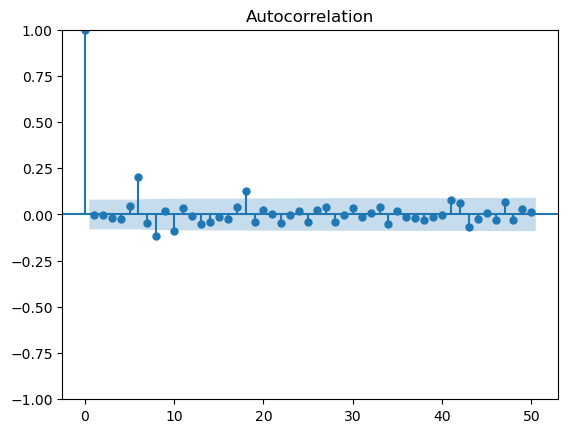

In [94]:
plot_acf(residuals_1, lags=50)
plt.show()

In [95]:
acorr_ljungbox(residuals_1)

,lb_stat,lb_pvalue
1,0.005023,0.943498
2,0.008889,0.995566
3,0.289999,0.961898
4,0.720733,0.948748
5,1.953146,0.855589
6,27.462873,0.000119
7,28.646676,0.000168
8,37.134517,0.000011
9,37.334678,0.000023
10,42.063374,0.000007


In [96]:
runstest_1samp(residuals_1)

(0.28606136345886335, 0.7748311230208311)

#### به دلیل اینکه در لگ ششم یک خودهمبستگی معنادار داریم از p=6 استفاده می کنیم

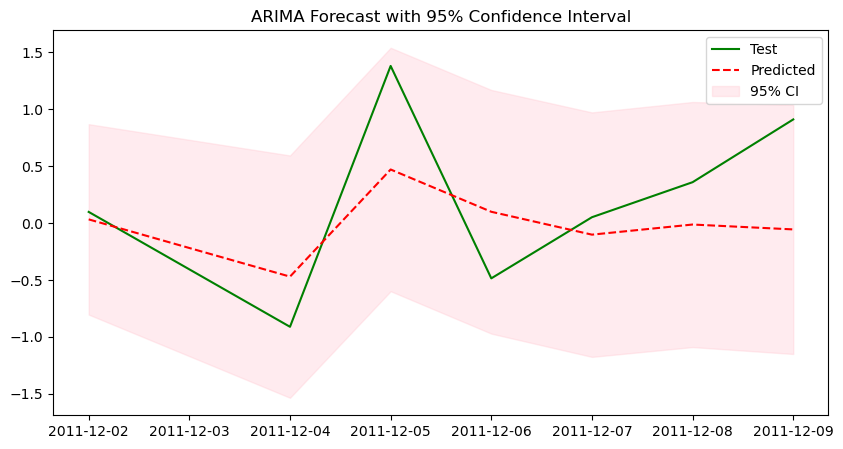

      lb_stat  lb_pvalue
1    0.029163   0.864403
2    0.905345   0.635926
3    0.924365   0.819544
4    1.211084   0.876270
5    1.243768   0.940610
6    1.564414   0.955102
7    1.718893   0.973752
8    9.578335   0.295876
9    9.830502   0.364381
10  12.797714   0.235203
11  12.857713   0.302727
12  12.908529   0.375724
13  13.263136   0.427698
14  13.288788   0.503921
15  13.373594   0.573466
16  13.493061   0.636423
17  14.607560   0.623725
18  27.918582   0.063305
19  28.099690   0.081529
20  28.419309   0.099839
21  28.422645   0.128567
22  29.450297   0.132448
23  29.502284   0.164229
24  29.724565   0.194049
25  30.264915   0.214523
26  30.371630   0.252502
27  31.211892   0.262528
28  31.392347   0.299937
29  31.399575   0.346835
30  33.737240   0.291459
31  33.785516   0.334373
32  33.819622   0.379670
33  34.636300   0.389729
34  36.138891   0.368935
35  36.185849   0.413039
36  36.775502   0.432790
37  36.776264   0.479434
38  37.228452   0.504952
39  37.402928   0.542814


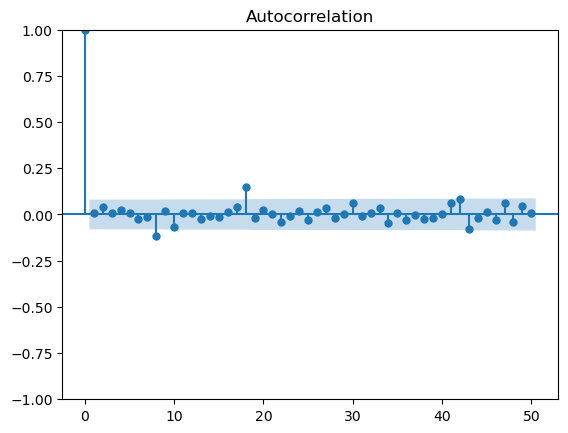

In [97]:
model_1 = ARIMA(train_d, order=(6,0,2), seasonal_order=(1,0,1,12))
model_fit_1 = model_1.fit()
pred_train = model_fit_1.predict(start=0, end=len(train_d)-1)
forecast_1 = model_fit_1.get_forecast(steps=len(test_d))
pred_test_1 = forecast_1.predicted_mean
ci = forecast_1.conf_int()

# Plot
plt.figure(figsize=(10,5))
plt.plot(test_d.index, test_d, label='Test', color='green')
plt.plot(test_d.index, pred_test_1, label='Predicted', color='red', linestyle='--')


residuals_1 = model_fit_1.resid
# Fill the area between lower and upper bounds
plt.fill_between(test_d.index,
                 ci.iloc[:, 0],   # lower bound
                 ci.iloc[:, 1],   # upper bound
                 color='pink', alpha=0.3, label='95% CI')

plt.legend()
plt.title("ARIMA Forecast with 95% Confidence Interval")
plt.show()


print(acorr_ljungbox(residuals_1 , lags=50))

plot_acf(residuals_1, lags=50)
plt.show()

که همچنان در بعضی لگ ها هنوز معناداری داریم و از مدل قوی تری استفاده می کنیم


In [98]:
model_1 = ARIMA(train_d, order=(6,0,6), seasonal_order=(1,0,1,12))
model_fit_1 = model_1.fit()
pred_train = model_fit_1.predict(start=0, end=len(train_d)-1)
forecast_1 = model_fit_1.get_forecast(steps=len(test_d))
pred_test_1 = forecast_1.predicted_mean


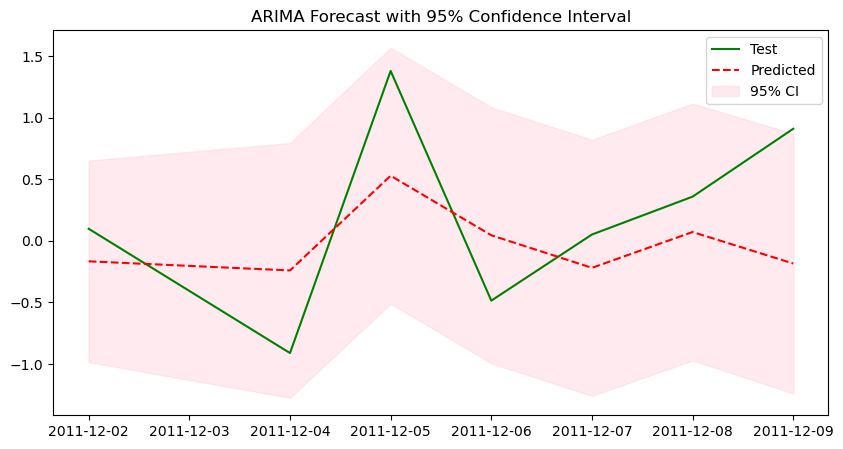

      lb_stat  lb_pvalue
1    0.015851   0.899809
2    0.398449   0.819366
3    0.923988   0.819635
4    0.928436   0.920446
5    0.944886   0.966887
6    1.135496   0.979951
7    1.214580   0.990587
8    3.863130   0.869256
9    3.892891   0.918320
10   4.211534   0.937300
11   4.378777   0.957500
12   4.380879   0.975542
13   4.384472   0.986372
14   4.785117   0.988584
15   5.817813   0.982648
16   6.981091   0.973624
17   7.213936   0.980606
18   7.629190   0.983661
19   7.636425   0.989970
20   8.959918   0.983367
21   9.273553   0.986893
22   9.334605   0.991401
23   9.829333   0.992283
24  10.000890   0.994543
25  10.002946   0.996645
26  11.176412   0.994942
27  11.808710   0.994996
28  11.884750   0.996661
29  12.190054   0.997382
30  12.279627   0.998258
31  12.286393   0.998924
32  12.471177   0.999240
33  12.784395   0.999404
34  12.853329   0.999620
35  12.854691   0.999774
36  13.421926   0.999779
37  13.539379   0.999855
38  13.725097   0.999899
39  13.884626   0.999931


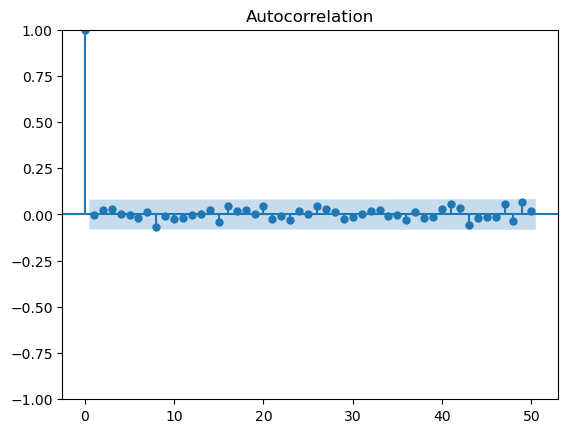

In [99]:
ci = forecast_1.conf_int()

# Plot
plt.figure(figsize=(10,5))
plt.plot(test_d.index, test_d, label='Test', color='green')
plt.plot(test_d.index, pred_test_1, label='Predicted', color='red', linestyle='--')


residuals_1 = model_fit_1.resid
# Fill the area between lower and upper bounds
plt.fill_between(test_d.index,
                 ci.iloc[:, 0],   # lower bound
                 ci.iloc[:, 1],   # upper bound
                 color='pink', alpha=0.3, label='95% CI')

plt.legend()
plt.title("ARIMA Forecast with 95% Confidence Interval")
plt.show()


print(acorr_ljungbox(residuals_1 , lags=50))

plot_acf(residuals_1, lags=50)
plt.show()

همانطور که در نمودار خودهمبستگی قابل مشاهده هست نمودار خودهمبستگی که داریم در فضای معنادار قرار داره و مدل ما کارش رو انجام دارد  و ضرایب باکس-پیرز ما هم بالاتر از ۰.۱۵ هستند که لگ ها ما در موقعیتی خوبی قرار دارند

# بررسی نهایی مدل

## بررسی باقی مانده های مدل

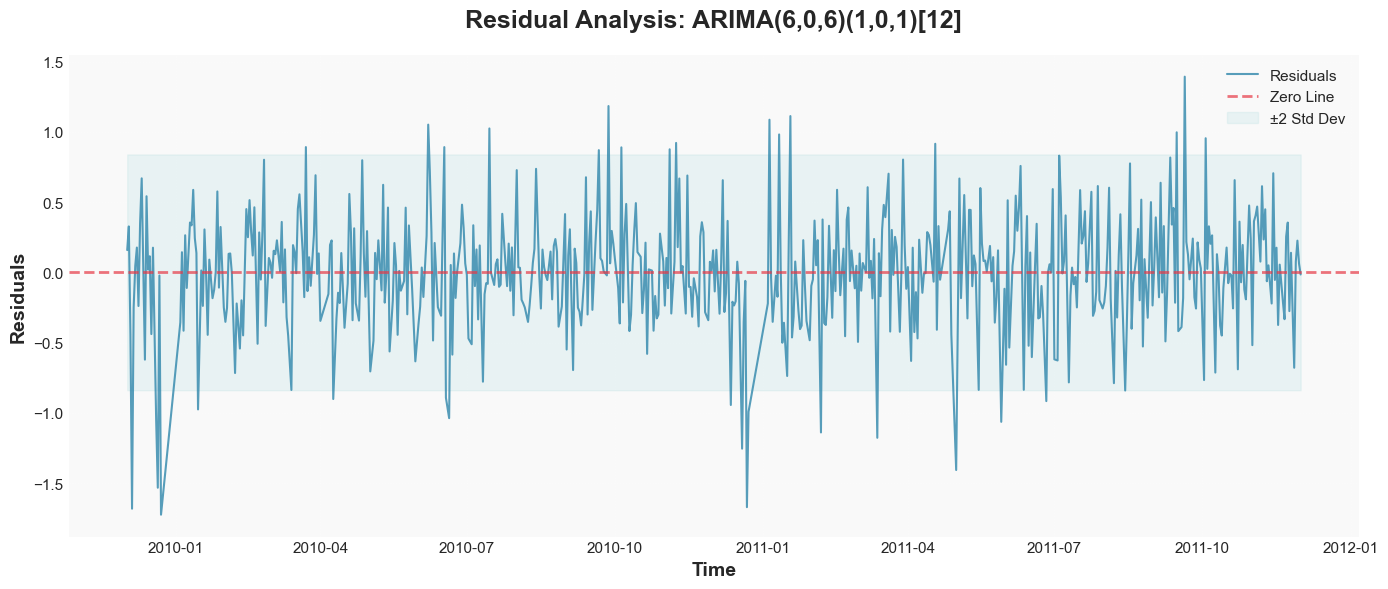

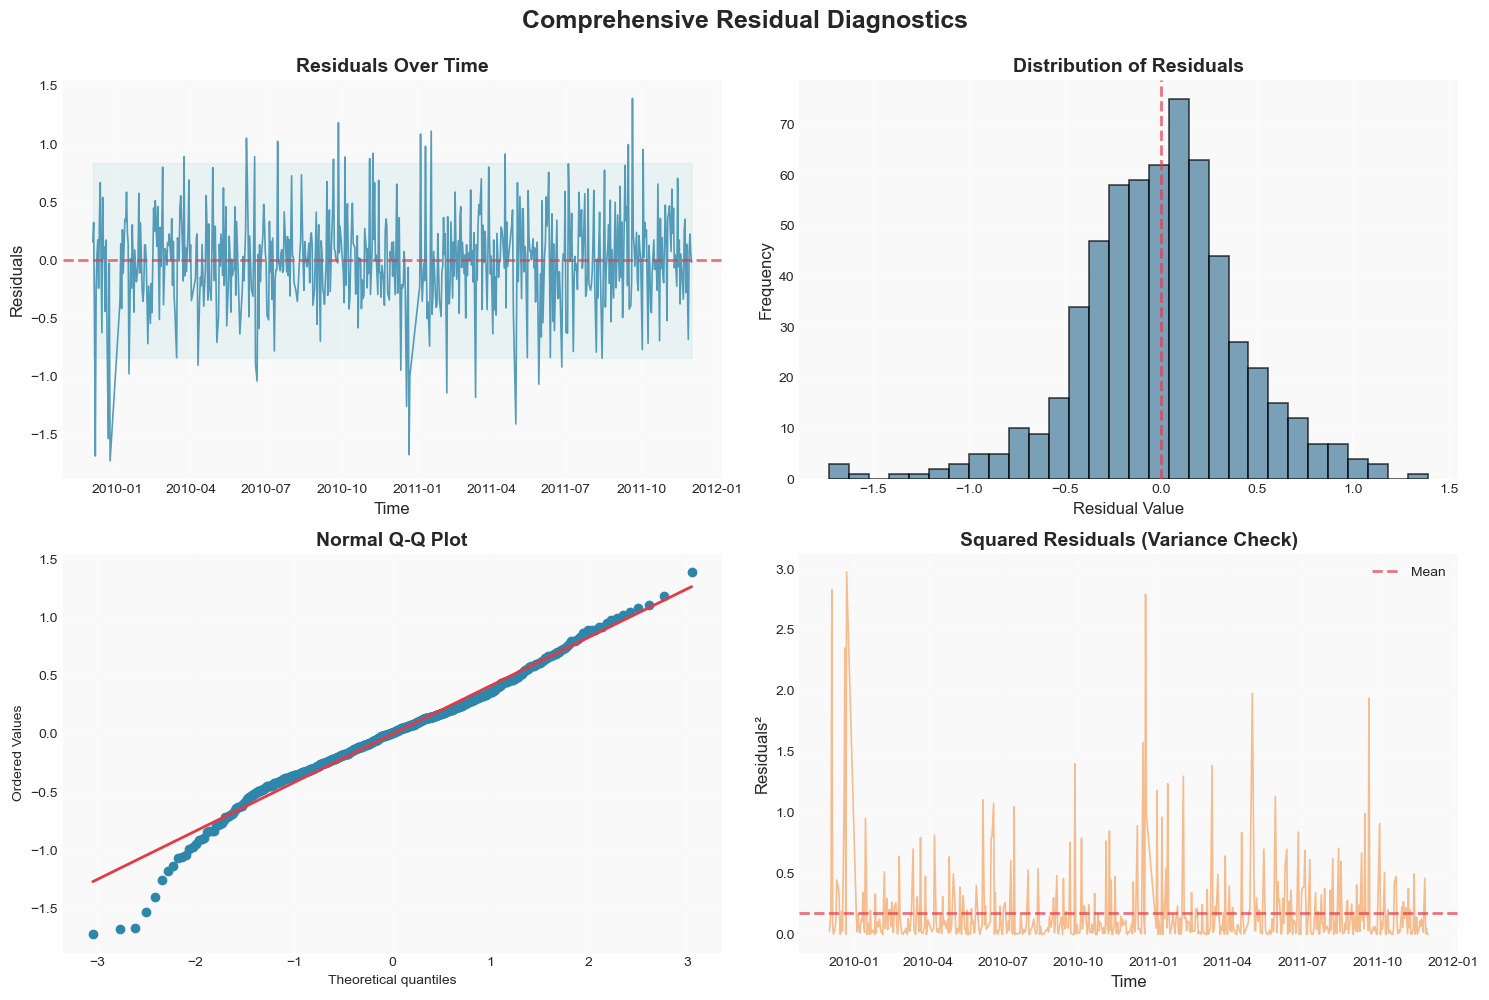

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with custom size
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

# Plot residuals with styling
ax.plot(residuals_1.index, residuals_1.values, 
        color='#2E86AB', linewidth=1.5, alpha=0.8, label='Residuals')

# Add horizontal line at zero
ax.axhline(y=0, color='#E63946', linestyle='--', linewidth=2, 
           alpha=0.7, label='Zero Line')

# Add confidence bands (±2 standard deviations)
std_residuals = np.std(residuals_1)
ax.fill_between(residuals_1.index, 
                -2*std_residuals, 
                2*std_residuals, 
                alpha=0.2, color='#A8DADC', 
                label='±2 Std Dev')

# Styling
ax.set_title('Residual Analysis: ARIMA(6,0,6)(1,0,1)[12]', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Time', fontsize=14, fontweight='bold')
ax.set_ylabel('Residuals', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)

# Add subtle background color
ax.set_facecolor('#F9F9F9')

# Improve tick labels
ax.tick_params(axis='both', which='major', labelsize=11)

# Tight layout
plt.tight_layout()
plt.show()

# Optional: Create a multi-panel diagnostic plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10), dpi=100)

# 1. Residuals over time
axes[0, 0].plot(residuals_1.index, residuals_1.values, 
                color='#2E86AB', linewidth=1.2, alpha=0.8)
axes[0, 0].axhline(y=0, color='#E63946', linestyle='--', linewidth=2, alpha=0.7)
axes[0, 0].fill_between(residuals_1.index, 
                         -2*std_residuals, 2*std_residuals, 
                         alpha=0.2, color='#A8DADC')
axes[0, 0].set_title('Residuals Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Time', fontsize=12)
axes[0, 0].set_ylabel('Residuals', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_facecolor('#F9F9F9')

# 2. Histogram of residuals
axes[0, 1].hist(residuals_1, bins=30, color='#457B9D', 
                alpha=0.7, edgecolor='black', linewidth=1.2)
axes[0, 1].axvline(x=0, color='#E63946', linestyle='--', linewidth=2, alpha=0.7)
axes[0, 1].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Residual Value', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_facecolor('#F9F9F9')

# 3. Q-Q plot
from scipy import stats
stats.probplot(residuals_1, dist="norm", plot=axes[1, 0])
axes[1, 0].get_lines()[0].set_markerfacecolor('#2E86AB')
axes[1, 0].get_lines()[0].set_markeredgecolor('#2E86AB')
axes[1, 0].get_lines()[0].set_markersize(6)
axes[1, 0].get_lines()[1].set_color('#E63946')
axes[1, 0].get_lines()[1].set_linewidth(2)
axes[1, 0].set_title('Normal Q-Q Plot', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_facecolor('#F9F9F9')

# 4. Residuals squared (for heteroscedasticity check)
axes[1, 1].plot(residuals_1.index, residuals_1**2, 
                color='#F4A261', linewidth=1.2, alpha=0.7)
axes[1, 1].axhline(y=np.mean(residuals_1**2), 
                   color='#E63946', linestyle='--', linewidth=2, alpha=0.7,
                   label='Mean')
axes[1, 1].set_title('Squared Residuals (Variance Check)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Time', fontsize=12)
axes[1, 1].set_ylabel('Residuals²', fontsize=12)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_facecolor('#F9F9F9')

# Overall title
fig.suptitle('Comprehensive Residual Diagnostics', 
             fontsize=18, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

## توان دوم باقی مانده ها
- در بررسی توان دوم باقی مانده ها مشاهده شد که واریانس ما ثابت هست که از طریق رسم نمودار و بررسی خودهمبستگی آن اطمینان حاصل شد

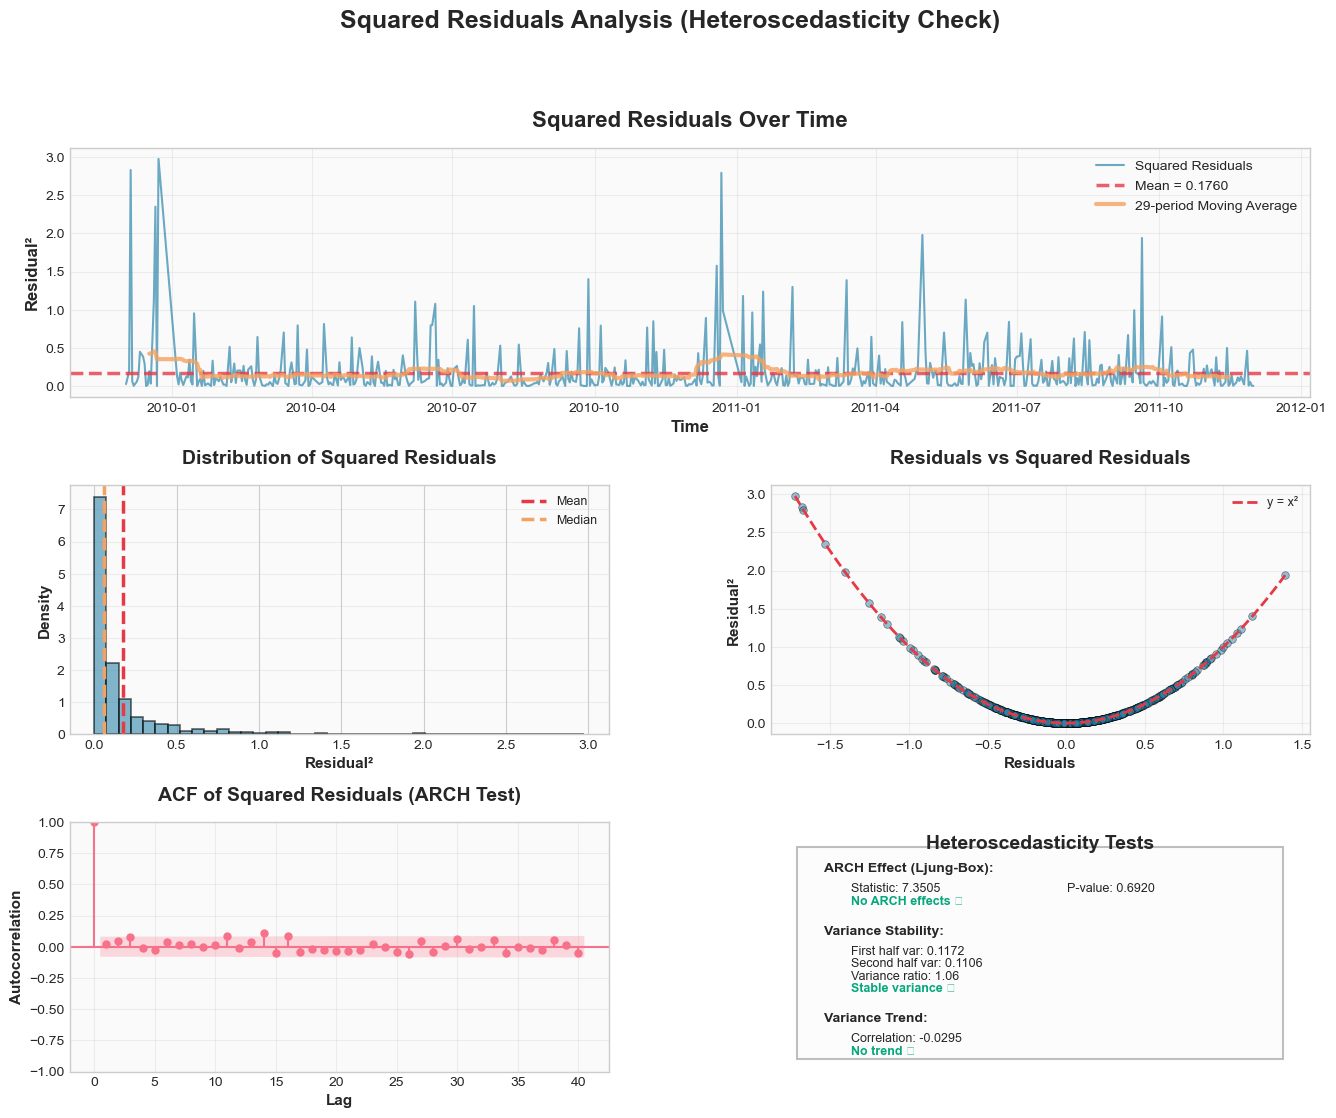


SQUARED RESIDUALS INTERPRETATION

Mean of squared residuals: 0.175996
Std of squared residuals:  0.337097
Variance ratio (1st/2nd half): 1.06
Time correlation: -0.0295

----------------------------------------------------------------------
WHAT TO LOOK FOR:
----------------------------------------------------------------------
✓ GOOD: Random scatter around mean, no patterns
✓ GOOD: Constant variance over time (ratio < 2)
✓ GOOD: No autocorrelation in squared residuals (ARCH test p > 0.05)
✓ GOOD: Moving average is roughly flat

✗ BAD: Increasing/decreasing trend over time
✗ BAD: Periods of high variance followed by low variance
✗ BAD: Autocorrelation in squared residuals (volatility clustering)
✗ BAD: Fan-shaped pattern (variance increases with level)

✓ OVERALL: Residuals show HOMOSCEDASTICITY (constant variance)
  Your model's variance assumptions are satisfied!



In [109]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_squared_residuals(residuals, data_name='Residuals'):
    """
    Comprehensive analysis of squared residuals for heteroscedasticity detection
    
    Parameters:
    -----------
    residuals : array-like or Series
        Model residuals
    data_name : str
        Name for labeling
    """
    
    # Calculate squared residuals
    squared_residuals = residuals ** 2
    
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Create figure
    fig = plt.figure(figsize=(16, 12), dpi=100)
    gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)
    
    colors = {
        'primary': '#2E86AB',
        'secondary': '#A23B72',
        'good': '#06A77D',
        'warning': '#F4A261',
        'bad': '#E63946'
    }
    
    # ============================================
    # 1. Squared Residuals Over Time
    # ============================================
    ax1 = fig.add_subplot(gs[0, :])
    
    ax1.plot(squared_residuals.index, squared_residuals.values,
             color=colors['primary'], linewidth=1.5, alpha=0.7,
             label='Squared Residuals')
    
    # Add mean line
    mean_sq_resid = np.mean(squared_residuals)
    ax1.axhline(y=mean_sq_resid, color=colors['bad'], 
                linestyle='--', linewidth=2.5, alpha=0.8,
                label=f'Mean = {mean_sq_resid:.4f}')
    
    # Add moving average to see trends
    window = max(10, len(squared_residuals) // 20)
    ma = squared_residuals.rolling(window=window, center=True).mean()
    ax1.plot(ma.index, ma.values, color=colors['warning'], 
             linewidth=3, alpha=0.8, label=f'{window}-period Moving Average')
    
    ax1.set_title('Squared Residuals Over Time', 
                  fontsize=16, fontweight='bold', pad=15)
    ax1.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Residual²', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_facecolor('#FAFAFA')
    
    # ============================================
    # 2. Distribution of Squared Residuals
    # ============================================
    ax2 = fig.add_subplot(gs[1, 0])
    
    ax2.hist(squared_residuals, bins=40, color=colors['primary'],
             alpha=0.6, edgecolor='black', linewidth=1.2, density=True)
    
    ax2.axvline(x=mean_sq_resid, color=colors['bad'], 
                linestyle='--', linewidth=2.5, label='Mean')
    ax2.axvline(x=np.median(squared_residuals), color=colors['warning'],
                linestyle='--', linewidth=2.5, label='Median')
    
    ax2.set_title('Distribution of Squared Residuals', 
                  fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('Residual²', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Density', fontsize=11, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_facecolor('#FAFAFA')
    
    # ============================================
    # 3. Residuals vs Squared Residuals
    # ============================================
    ax3 = fig.add_subplot(gs[1, 1])
    
    ax3.scatter(residuals, squared_residuals, 
                alpha=0.5, s=30, color=colors['primary'], edgecolors='black', linewidth=0.5)
    
    # Add reference curves
    x_range = np.linspace(residuals.min(), residuals.max(), 100)
    ax3.plot(x_range, x_range**2, color=colors['bad'], 
             linewidth=2, linestyle='--', label='y = x²')
    
    ax3.set_title('Residuals vs Squared Residuals', 
                  fontsize=14, fontweight='bold', pad=15)
    ax3.set_xlabel('Residuals', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Residual²', fontsize=11, fontweight='bold')
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)
    ax3.set_facecolor('#FAFAFA')
    
    # ============================================
    # 4. ACF of Squared Residuals
    # ============================================
    ax4 = fig.add_subplot(gs[2, 0])
    
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(squared_residuals, lags=40, ax=ax4, alpha=0.05)
    ax4.set_title('ACF of Squared Residuals (ARCH Test)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax4.set_xlabel('Lag', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Autocorrelation', fontsize=11, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.set_facecolor('#FAFAFA')
    
    # ============================================
    # 5. Statistical Tests Summary
    # ============================================
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.axis('off')
    
    # Perform statistical tests
    
    # 1. Ljung-Box test on squared residuals (ARCH effects)
    from statsmodels.stats.diagnostic import acorr_ljungbox
    lb_test = acorr_ljungbox(squared_residuals, lags=[10], return_df=True)
    lb_stat = lb_test['lb_stat'].values[0]
    lb_pval = lb_test['lb_pvalue'].values[0]
    
    # 2. Breusch-Pagan test (if we have fitted values)
    # For now, we'll use a simpler variance stability test
    
    # Split into halves and compare variances
    mid_point = len(squared_residuals) // 2
    first_half_var = squared_residuals.iloc[:mid_point].var()
    second_half_var = squared_residuals.iloc[mid_point:].var()
    variance_ratio = max(first_half_var, second_half_var) / min(first_half_var, second_half_var)
    
    # 3. Check for trend in squared residuals
    time_index = np.arange(len(squared_residuals))
    correlation = np.corrcoef(time_index, squared_residuals)[0, 1]
    
    # Display results
    ax5.text(0.5, 0.95, 'Heteroscedasticity Tests', 
             ha='center', va='top', fontsize=14, fontweight='bold',
             transform=ax5.transAxes)
    
    y_pos = 0.80
    
    # Test 1: Ljung-Box on squared residuals
    ax5.text(0.1, y_pos, 'ARCH Effect (Ljung-Box):', 
             fontsize=10, fontweight='bold', transform=ax5.transAxes)
    y_pos -= 0.08
    ax5.text(0.15, y_pos, f'Statistic: {lb_stat:.4f}', 
             fontsize=9, transform=ax5.transAxes)
    ax5.text(0.55, y_pos, f'P-value: {lb_pval:.4f}', 
             fontsize=9, transform=ax5.transAxes)
    y_pos -= 0.05
    
    arch_result = 'No ARCH effects ✓' if lb_pval > 0.05 else 'ARCH effects detected ✗'
    arch_color = colors['good'] if lb_pval > 0.05 else colors['bad']
    ax5.text(0.15, y_pos, arch_result, fontsize=9, 
             color=arch_color, fontweight='bold', transform=ax5.transAxes)
    y_pos -= 0.12
    
    # Test 2: Variance stability
    ax5.text(0.1, y_pos, 'Variance Stability:', 
             fontsize=10, fontweight='bold', transform=ax5.transAxes)
    y_pos -= 0.08
    ax5.text(0.15, y_pos, f'First half var: {first_half_var:.4f}', 
             fontsize=9, transform=ax5.transAxes)
    y_pos -= 0.05
    ax5.text(0.15, y_pos, f'Second half var: {second_half_var:.4f}', 
             fontsize=9, transform=ax5.transAxes)
    y_pos -= 0.05
    ax5.text(0.15, y_pos, f'Variance ratio: {variance_ratio:.2f}', 
             fontsize=9, transform=ax5.transAxes)
    y_pos -= 0.05
    
    var_result = 'Stable variance ✓' if variance_ratio < 2 else 'Unstable variance ✗'
    var_color = colors['good'] if variance_ratio < 2 else colors['bad']
    ax5.text(0.15, y_pos, var_result, fontsize=9, 
             color=var_color, fontweight='bold', transform=ax5.transAxes)
    y_pos -= 0.12
    
    # Test 3: Trend in variance
    ax5.text(0.1, y_pos, 'Variance Trend:', 
             fontsize=10, fontweight='bold', transform=ax5.transAxes)
    y_pos -= 0.08
    ax5.text(0.15, y_pos, f'Correlation: {correlation:.4f}', 
             fontsize=9, transform=ax5.transAxes)
    y_pos -= 0.05
    
    trend_result = 'No trend ✓' if abs(correlation) < 0.1 else 'Trend detected ✗'
    trend_color = colors['good'] if abs(correlation) < 0.1 else colors['bad']
    ax5.text(0.15, y_pos, trend_result, fontsize=9, 
             color=trend_color, fontweight='bold', transform=ax5.transAxes)
    
    # Add background box
    from matplotlib.patches import Rectangle
    rect = Rectangle((0.05, 0.05), 0.90, 0.85, 
                     transform=ax5.transAxes,
                     facecolor='#FAFAFA', edgecolor='gray', 
                     linewidth=1.5, alpha=0.5)
    ax5.add_patch(rect)
    
    # Overall title
    fig.suptitle('Squared Residuals Analysis (Heteroscedasticity Check)', 
                 fontsize=18, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    print("\n" + "="*70)
    print("SQUARED RESIDUALS INTERPRETATION")
    print("="*70)
    print(f"\nMean of squared residuals: {mean_sq_resid:.6f}")
    print(f"Std of squared residuals:  {np.std(squared_residuals):.6f}")
    print(f"Variance ratio (1st/2nd half): {variance_ratio:.2f}")
    print(f"Time correlation: {correlation:.4f}")
    
    print("\n" + "-"*70)
    print("WHAT TO LOOK FOR:")
    print("-"*70)
    print("✓ GOOD: Random scatter around mean, no patterns")
    print("✓ GOOD: Constant variance over time (ratio < 2)")
    print("✓ GOOD: No autocorrelation in squared residuals (ARCH test p > 0.05)")
    print("✓ GOOD: Moving average is roughly flat")
    
    print("\n✗ BAD: Increasing/decreasing trend over time")
    print("✗ BAD: Periods of high variance followed by low variance")
    print("✗ BAD: Autocorrelation in squared residuals (volatility clustering)")
    print("✗ BAD: Fan-shaped pattern (variance increases with level)")
    
    print("\n" + "="*70)
    
    # Overall assessment
    issues = []
    if lb_pval < 0.05:
        issues.append("ARCH effects (volatility clustering)")
    if variance_ratio > 2:
        issues.append("Non-constant variance")
    if abs(correlation) > 0.1:
        issues.append("Trend in variance")
    
    if len(issues) == 0:
        print("✓ OVERALL: Residuals show HOMOSCEDASTICITY (constant variance)")
        print("  Your model's variance assumptions are satisfied!")
    else:
        print("⚠ OVERALL: Potential HETEROSCEDASTICITY detected:")
        for issue in issues:
            print(f"  - {issue}")
        print("\n  Consider:")
        print("  1. Adding explanatory variables")
        print("  2. Using ARCH/GARCH models for volatility")
        print("  3. Weighted least squares")
        print("  4. Transforming the data differently")
    
    print("="*70 + "\n")
    
    return squared_residuals, {
        'mean': mean_sq_resid,
        'std': np.std(squared_residuals),
        'variance_ratio': variance_ratio,
        'arch_pvalue': lb_pval,
        'time_correlation': correlation
    }

# Usage:
# squared_resid, diagnostics = analyze_squared_residuals(residuals_1, 'ARIMA(6,0,6)(1,0,1)[12]')
squared_resid, diagnostics = analyze_squared_residuals(residuals_1, 'ARIMA(6,0,6)(1,0,1)[12]')

## نرمالیتی باقی مانده ها
- در این تست ها فقط در کلموگروف-اسمیرنوف مورد قبول شد و در تست ها دیگر مورد قبول در نظر گرفته نشد

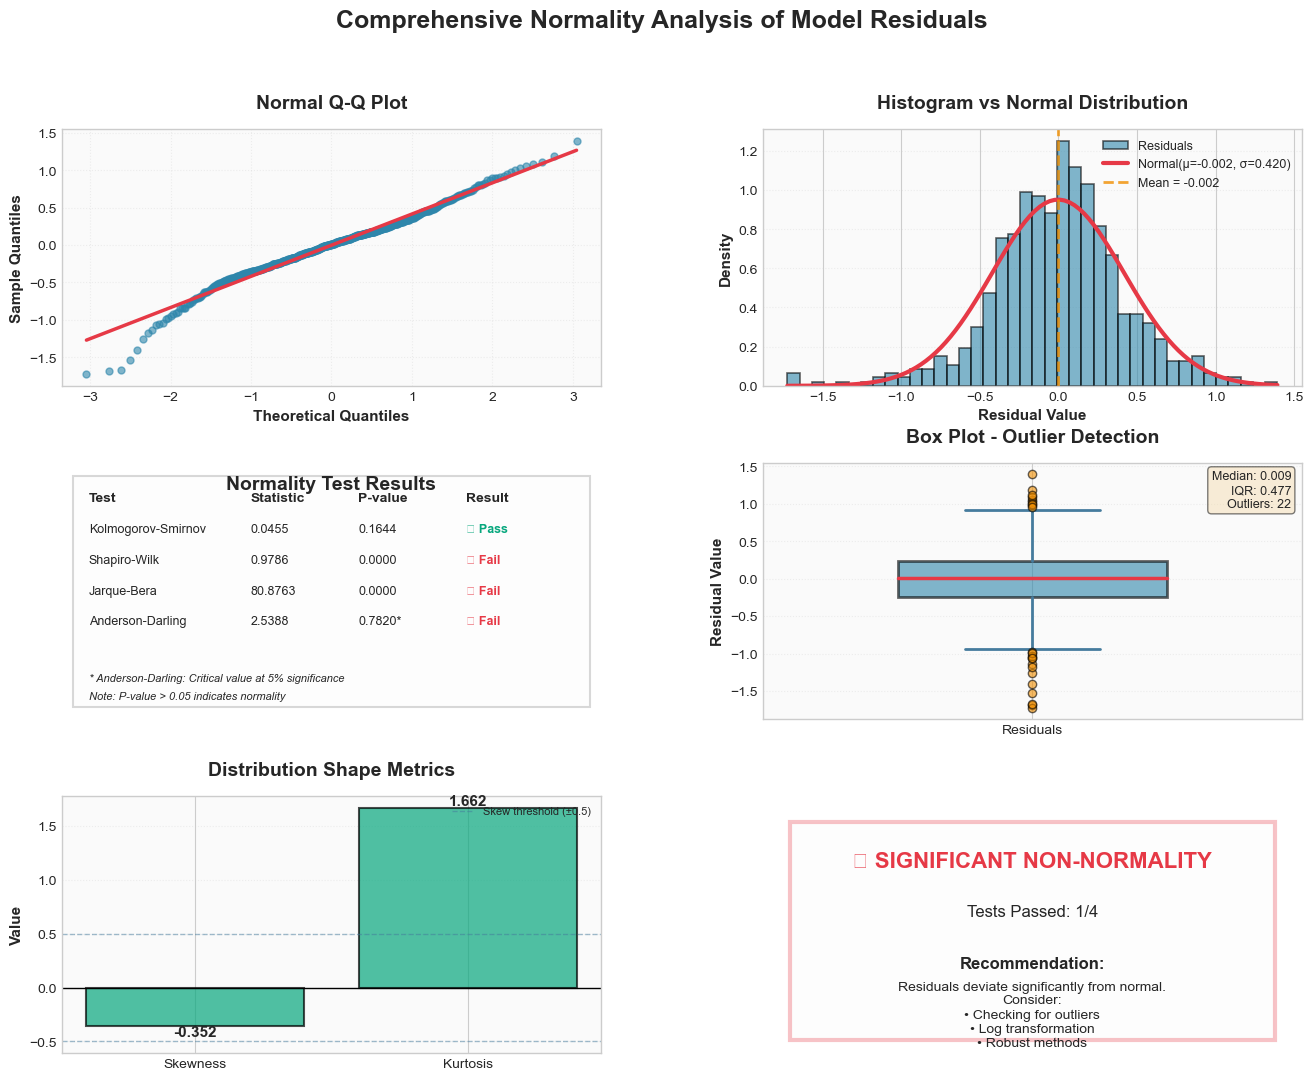


NORMALITY TEST SUMMARY
Kolmogorov-Smirnov: stat=0.0455, p=0.1644
Shapiro-Wilk:       stat=0.9786, p=0.0000
Jarque-Bera:        stat=80.8763, p=0.0000
Anderson-Darling:   stat=2.5388

Skewness: -0.3521
Kurtosis: 1.6616

Tests Passed: 1/4


In [110]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import kstest, shapiro, jarque_bera, anderson

def beautiful_normality_test(residuals):
    """
    Create a comprehensive and beautiful normality test visualization
    
    Parameters:
    -----------
    residuals : array-like
        Model residuals to test
    """
    
    # Perform multiple normality tests
    ks_stat, ks_pval = kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals)))
    sw_stat, sw_pval = shapiro(residuals)
    jb_stat, jb_pval = jarque_bera(residuals)
    ad_result = anderson(residuals, dist='norm')
    
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Create figure with 2x2 subplots
    fig = plt.figure(figsize=(16, 12), dpi=100)
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # Color scheme
    colors = {
        'primary': '#2E86AB',
        'secondary': '#A23B72',
        'accent': '#F18F01',
        'pass': '#06A77D',
        'fail': '#E63946',
        'neutral': '#457B9D'
    }
    
    # ============================================
    # 1. Q-Q Plot (Top Left)
    # ============================================
    ax1 = fig.add_subplot(gs[0, 0])
    stats.probplot(residuals, dist="norm", plot=ax1)
    ax1.get_lines()[0].set_markerfacecolor(colors['primary'])
    ax1.get_lines()[0].set_markeredgecolor(colors['primary'])
    ax1.get_lines()[0].set_markersize(5)
    ax1.get_lines()[0].set_alpha(0.6)
    ax1.get_lines()[1].set_color(colors['fail'])
    ax1.get_lines()[1].set_linewidth(2.5)
    ax1.set_title('Normal Q-Q Plot', fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlabel('Theoretical Quantiles', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Sample Quantiles', fontsize=11, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
    ax1.set_facecolor('#FAFAFA')
    
    # ============================================
    # 2. Histogram with Normal Overlay (Top Right)
    # ============================================
    ax2 = fig.add_subplot(gs[0, 1])
    
    # Histogram
    n, bins, patches = ax2.hist(residuals, bins=40, density=True, 
                                 color=colors['primary'], alpha=0.6, 
                                 edgecolor='black', linewidth=1.2,
                                 label='Residuals')
    
    # Overlay fitted normal distribution
    mu, sigma = np.mean(residuals), np.std(residuals)
    x = np.linspace(residuals.min(), residuals.max(), 100)
    ax2.plot(x, stats.norm.pdf(x, mu, sigma), 
             color=colors['fail'], linewidth=3, 
             label=f'Normal(μ={mu:.3f}, σ={sigma:.3f})')
    
    ax2.axvline(x=mu, color=colors['accent'], linestyle='--', 
                linewidth=2, alpha=0.8, label=f'Mean = {mu:.3f}')
    ax2.set_title('Histogram vs Normal Distribution', fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('Residual Value', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Density', fontsize=11, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=9, framealpha=0.95)
    ax2.grid(True, alpha=0.3, axis='y', linestyle=':', linewidth=0.8)
    ax2.set_facecolor('#FAFAFA')
    
    # ============================================
    # 3. Statistical Tests Summary (Middle Left)
    # ============================================
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.axis('off')
    
    # Create test results table
    test_results = [
        ['Test', 'Statistic', 'P-value', 'Result'],
        ['─'*20, '─'*12, '─'*12, '─'*10],
        ['Kolmogorov-Smirnov', f'{ks_stat:.4f}', f'{ks_pval:.4f}', 
         '✓ Pass' if ks_pval > 0.05 else '✗ Fail'],
        ['Shapiro-Wilk', f'{sw_stat:.4f}', f'{sw_pval:.4f}', 
         '✓ Pass' if sw_pval > 0.05 else '✗ Fail'],
        ['Jarque-Bera', f'{jb_stat:.4f}', f'{jb_pval:.4f}', 
         '✓ Pass' if jb_pval > 0.05 else '✗ Fail'],
        ['Anderson-Darling', f'{ad_result.statistic:.4f}', 
         f'{ad_result.critical_values[2]:.4f}*', 
         '✓ Pass' if ad_result.statistic < ad_result.critical_values[2] else '✗ Fail']
    ]
    
    # Title
    ax3.text(0.5, 0.95, 'Normality Test Results', 
             ha='center', va='top', fontsize=14, fontweight='bold',
             transform=ax3.transAxes)
    
    # Table
    y_pos = 0.85
    for i, row in enumerate(test_results):
        if i == 0:  # Header
            ax3.text(0.05, y_pos, row[0], fontsize=10, fontweight='bold', 
                    transform=ax3.transAxes)
            ax3.text(0.35, y_pos, row[1], fontsize=10, fontweight='bold', 
                    transform=ax3.transAxes)
            ax3.text(0.55, y_pos, row[2], fontsize=10, fontweight='bold', 
                    transform=ax3.transAxes)
            ax3.text(0.75, y_pos, row[3], fontsize=10, fontweight='bold', 
                    transform=ax3.transAxes)
        elif i == 1:  # Separator
            continue
        else:  # Data rows
            color = colors['pass'] if '✓' in row[3] else colors['fail']
            ax3.text(0.05, y_pos, row[0], fontsize=9, transform=ax3.transAxes)
            ax3.text(0.35, y_pos, row[1], fontsize=9, transform=ax3.transAxes)
            ax3.text(0.55, y_pos, row[2], fontsize=9, transform=ax3.transAxes)
            ax3.text(0.75, y_pos, row[3], fontsize=9, fontweight='bold', 
                    color=color, transform=ax3.transAxes)
        y_pos -= 0.12
    
    # Note
    ax3.text(0.05, 0.15, '* Anderson-Darling: Critical value at 5% significance',
             fontsize=8, style='italic', transform=ax3.transAxes)
    ax3.text(0.05, 0.08, 'Note: P-value > 0.05 indicates normality',
             fontsize=8, style='italic', transform=ax3.transAxes)
    
    # Add background box
    from matplotlib.patches import Rectangle
    rect = Rectangle((0.02, 0.05), 0.96, 0.90, 
                     transform=ax3.transAxes,
                     facecolor='#FAFAFA', edgecolor='gray', 
                     linewidth=1.5, alpha=0.3)
    ax3.add_patch(rect)
    
    # ============================================
    # 4. Box Plot (Middle Right)
    # ============================================
    ax4 = fig.add_subplot(gs[1, 1])
    bp = ax4.boxplot(residuals, vert=True, patch_artist=True,
                     widths=0.5,
                     boxprops=dict(facecolor=colors['primary'], alpha=0.6, linewidth=2),
                     whiskerprops=dict(color=colors['neutral'], linewidth=2),
                     capprops=dict(color=colors['neutral'], linewidth=2),
                     medianprops=dict(color=colors['fail'], linewidth=2.5),
                     flierprops=dict(marker='o', markerfacecolor=colors['accent'], 
                                    markersize=6, alpha=0.6))
    
    ax4.set_title('Box Plot - Outlier Detection', fontsize=14, fontweight='bold', pad=15)
    ax4.set_ylabel('Residual Value', fontsize=11, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y', linestyle=':', linewidth=0.8)
    ax4.set_facecolor('#FAFAFA')
    ax4.set_xticklabels(['Residuals'])
    
    # Add statistics text
    q1, median, q3 = np.percentile(residuals, [25, 50, 75])
    iqr = q3 - q1
    outliers = len(residuals[(residuals < q1 - 1.5*iqr) | (residuals > q3 + 1.5*iqr)])
    
    stats_text = f'Median: {median:.3f}\nIQR: {iqr:.3f}\nOutliers: {outliers}'
    ax4.text(0.98, 0.97, stats_text, transform=ax4.transAxes,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
             fontsize=9)
    
    # ============================================
    # 5. Skewness & Kurtosis (Bottom Left)
    # ============================================
    ax5 = fig.add_subplot(gs[2, 0])
    
    skew = stats.skew(residuals)
    kurt = stats.kurtosis(residuals)
    
    # Bar plot
    metrics = ['Skewness', 'Kurtosis']
    values = [skew, kurt]
    colors_bar = [colors['pass'] if abs(skew) < 0.5 else colors['fail'],
                  colors['pass'] if abs(kurt) < 3 else colors['fail']]
    
    bars = ax5.bar(metrics, values, color=colors_bar, alpha=0.7, 
                   edgecolor='black', linewidth=1.5)
    
    # Add reference lines
    ax5.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax5.axhline(y=0.5, color=colors['neutral'], linestyle='--', 
                linewidth=1, alpha=0.5, label='Skew threshold (±0.5)')
    ax5.axhline(y=-0.5, color=colors['neutral'], linestyle='--', 
                linewidth=1, alpha=0.5)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom' if val > 0 else 'top',
                fontsize=11, fontweight='bold')
    
    ax5.set_title('Distribution Shape Metrics', fontsize=14, fontweight='bold', pad=15)
    ax5.set_ylabel('Value', fontsize=11, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y', linestyle=':', linewidth=0.8)
    ax5.set_facecolor('#FAFAFA')
    ax5.legend(fontsize=8, loc='upper right')
    
    # ============================================
    # 6. Overall Assessment (Bottom Right)
    # ============================================
    ax6 = fig.add_subplot(gs[2, 1])
    ax6.axis('off')
    
    # Count passed tests
    tests_passed = sum([
        ks_pval > 0.05,
        sw_pval > 0.05,
        jb_pval > 0.05,
        ad_result.statistic < ad_result.critical_values[2]
    ])
    
    # Overall assessment
    if tests_passed >= 3:
        verdict = "✓ RESIDUALS APPEAR NORMAL"
        verdict_color = colors['pass']
        recommendation = "Your model residuals follow a normal distribution well.\nPrediction intervals should be reliable."
    elif tests_passed >= 2:
        verdict = "⚠ MILD DEPARTURE FROM NORMALITY"
        verdict_color = colors['accent']
        recommendation = "Residuals show some non-normality.\nForecasts are still valid, but prediction intervals\nmay be slightly off. Consider checking for outliers."
    else:
        verdict = "✗ SIGNIFICANT NON-NORMALITY"
        verdict_color = colors['fail']
        recommendation = "Residuals deviate significantly from normal.\nConsider:\n• Checking for outliers\n• Log transformation\n• Robust methods"
    
    # Display verdict
    ax6.text(0.5, 0.75, verdict, 
             ha='center', va='center', fontsize=16, fontweight='bold',
             color=verdict_color, transform=ax6.transAxes)
    
    ax6.text(0.5, 0.55, f'Tests Passed: {tests_passed}/4',
             ha='center', va='center', fontsize=12,
             transform=ax6.transAxes)
    
    ax6.text(0.5, 0.35, 'Recommendation:',
             ha='center', va='center', fontsize=12, fontweight='bold',
             transform=ax6.transAxes)
    
    ax6.text(0.5, 0.15, recommendation,
             ha='center', va='center', fontsize=10,
             transform=ax6.transAxes)
    
    # Add background box
    rect = Rectangle((0.05, 0.05), 0.90, 0.85, 
                     transform=ax6.transAxes,
                     facecolor='#FAFAFA', edgecolor=verdict_color, 
                     linewidth=3, alpha=0.3)
    ax6.add_patch(rect)
    
    # ============================================
    # Overall Title
    # ============================================
    fig.suptitle('Comprehensive Normality Analysis of Model Residuals', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n" + "="*60)
    print("NORMALITY TEST SUMMARY")
    print("="*60)
    print(f"Kolmogorov-Smirnov: stat={ks_stat:.4f}, p={ks_pval:.4f}")
    print(f"Shapiro-Wilk:       stat={sw_stat:.4f}, p={sw_pval:.4f}")
    print(f"Jarque-Bera:        stat={jb_stat:.4f}, p={jb_pval:.4f}")
    print(f"Anderson-Darling:   stat={ad_result.statistic:.4f}")
    print(f"\nSkewness: {skew:.4f}")
    print(f"Kurtosis: {kurt:.4f}")
    print(f"\nTests Passed: {tests_passed}/4")
    print("="*60)

# Usage:
# beautiful_normality_test(residuals_1)

beautiful_normality_test(residuals_1)

## داده های پرت در باقیمانده ها
- به نظر من وجود داده های پرت در باقی مانده به خاطر پیچیدگی داده ای که داشتم قابل حدس بود و رفتاری قابل پیش بینی

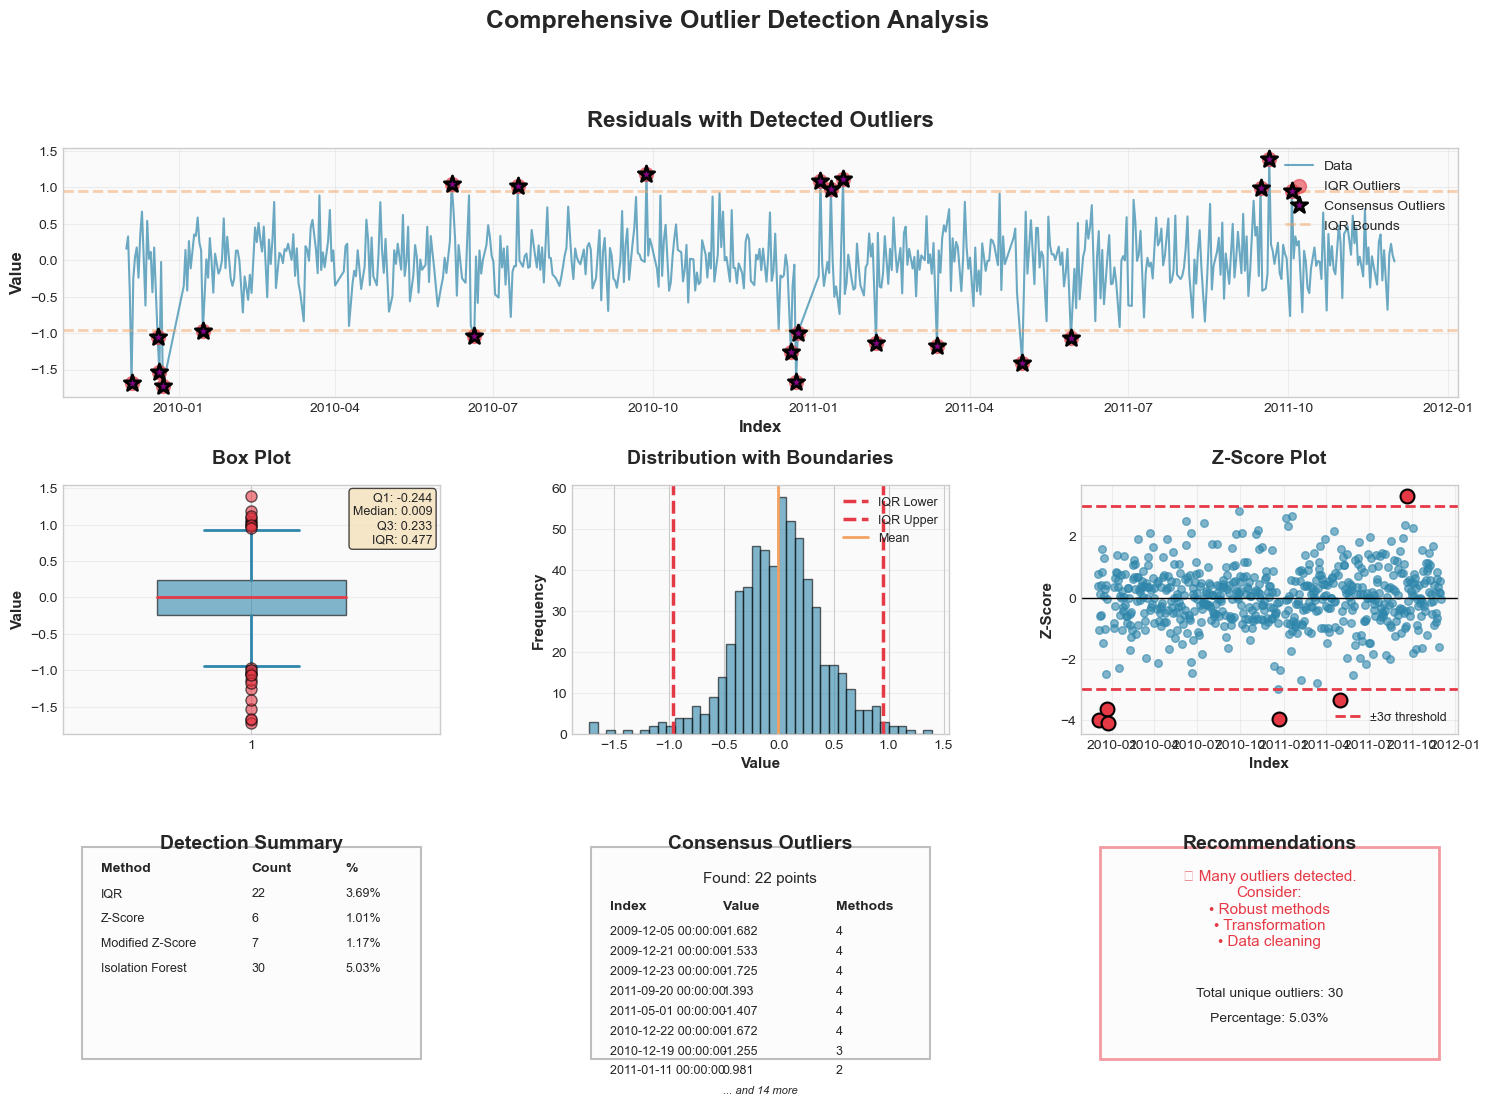


OUTLIER DETECTION SUMMARY

Total observations: 596

          Method  Outliers_Detected Percentage
             IQR                 22      3.69%
         Z-Score                  6      1.01%
Modified Z-Score                  7      1.17%
Isolation Forest                 30      5.03%

CONSENSUS OUTLIERS (detected by 2+ methods): 22
  Index 2009-12-05 00:00:00: Value = -1.6824, Detected by 4 methods
  Index 2009-12-21 00:00:00: Value = -1.5332, Detected by 4 methods
  Index 2009-12-23 00:00:00: Value = -1.7251, Detected by 4 methods
  Index 2011-09-20 00:00:00: Value = 1.3927, Detected by 4 methods
  Index 2011-05-01 00:00:00: Value = -1.4071, Detected by 4 methods
  Index 2010-12-22 00:00:00: Value = -1.6716, Detected by 4 methods
  Index 2010-12-19 00:00:00: Value = -1.2552, Detected by 3 methods
  Index 2011-01-11 00:00:00: Value = 0.9815, Detected by 2 methods
  Index 2011-09-15 00:00:00: Value = 0.9966, Detected by 2 methods
  Index 2011-05-29 00:00:00: Value = -1.0642, Detected

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def detect_outliers(data, data_name='Data', show_plots=True):
    """
    Comprehensive outlier detection using multiple methods
    
    Parameters:
    -----------
    data : array-like or Series
        Data to check for outliers (e.g., residuals or original time series)
    data_name : str
        Name of the data for labeling
    show_plots : bool
        Whether to show visualization
        
    Returns:
    --------
    outlier_summary : DataFrame
        Summary of outliers detected by each method
    """
    
    # Convert to pandas Series if not already
    if not isinstance(data, pd.Series):
        data = pd.Series(data)
    
    # Dictionary to store outlier indices from each method
    outlier_methods = {}
    
    # ============================================
    # Method 1: IQR (Interquartile Range)
    # ============================================
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    iqr_outliers = data[(data < lower_bound) | (data > upper_bound)]
    outlier_methods['IQR'] = iqr_outliers.index.tolist()
    
    # ============================================
    # Method 2: Z-Score (Standard Deviations)
    # ============================================
    z_scores = np.abs(stats.zscore(data))
    z_threshold = 3  # 3 standard deviations
    zscore_outliers = data[z_scores > z_threshold]
    outlier_methods['Z-Score'] = zscore_outliers.index.tolist()
    
    # ============================================
    # Method 3: Modified Z-Score (Robust)
    # ============================================
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    modified_z_scores = 0.6745 * (data - median) / mad
    mod_z_threshold = 3.5
    mod_z_outliers = data[np.abs(modified_z_scores) > mod_z_threshold]
    outlier_methods['Modified Z-Score'] = mod_z_outliers.index.tolist()
    
    # ============================================
    # Method 4: Isolation Forest
    # ============================================
    try:
        from sklearn.ensemble import IsolationForest
        iso_forest = IsolationForest(contamination=0.05, random_state=42)
        predictions = iso_forest.fit_predict(data.values.reshape(-1, 1))
        iso_outliers = data[predictions == -1]
        outlier_methods['Isolation Forest'] = iso_outliers.index.tolist()
    except ImportError:
        print("Note: sklearn not available, skipping Isolation Forest method")
        outlier_methods['Isolation Forest'] = []
    
    # ============================================
    # Create Summary DataFrame
    # ============================================
    summary_data = []
    all_outlier_indices = set()
    
    for method, indices in outlier_methods.items():
        all_outlier_indices.update(indices)
        summary_data.append({
            'Method': method,
            'Outliers_Detected': len(indices),
            'Percentage': f"{len(indices)/len(data)*100:.2f}%"
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Find consensus outliers (detected by multiple methods)
    outlier_counts = pd.Series(dtype=int)
    for indices in outlier_methods.values():
        for idx in indices:
            outlier_counts[idx] = outlier_counts.get(idx, 0) + 1
    
    consensus_outliers = outlier_counts[outlier_counts >= 2].sort_values(ascending=False)
    
    # ============================================
    # Visualization
    # ============================================
    if show_plots:
        fig = plt.figure(figsize=(18, 12), dpi=100)
        gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)
        
        colors = {
            'primary': '#2E86AB',
            'outlier': '#E63946',
            'warning': '#F4A261',
            'safe': '#06A77D'
        }
        
        # ============================================
        # 1. Time Series Plot with Outliers
        # ============================================
        ax1 = fig.add_subplot(gs[0, :])
        ax1.plot(data.index, data.values, color=colors['primary'], 
                linewidth=1.5, alpha=0.7, label='Data')
        
        # Mark outliers from each method with different markers
        if len(outlier_methods['IQR']) > 0:
            ax1.scatter(outlier_methods['IQR'], 
                       data.loc[outlier_methods['IQR']], 
                       color=colors['outlier'], s=100, marker='o', 
                       alpha=0.6, label='IQR Outliers', zorder=5)
        
        if len(consensus_outliers) > 0:
            ax1.scatter(consensus_outliers.index, 
                       data.loc[consensus_outliers.index], 
                       color='purple', s=150, marker='*', 
                       label='Consensus Outliers', zorder=6, edgecolors='black', linewidths=2)
        
        # Add threshold lines
        ax1.axhline(y=upper_bound, color=colors['warning'], 
                   linestyle='--', linewidth=2, alpha=0.5, label='IQR Bounds')
        ax1.axhline(y=lower_bound, color=colors['warning'], 
                   linestyle='--', linewidth=2, alpha=0.5)
        
        ax1.set_title(f'{data_name} with Detected Outliers', 
                     fontsize=16, fontweight='bold', pad=15)
        ax1.set_xlabel('Index', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Value', fontsize=12, fontweight='bold')
        ax1.legend(loc='upper right', fontsize=10)
        ax1.grid(True, alpha=0.3)
        ax1.set_facecolor('#FAFAFA')
        
        # ============================================
        # 2. Box Plot
        # ============================================
        ax2 = fig.add_subplot(gs[1, 0])
        bp = ax2.boxplot(data, vert=True, patch_artist=True, widths=0.5,
                        boxprops=dict(facecolor=colors['primary'], alpha=0.6),
                        whiskerprops=dict(color=colors['primary'], linewidth=2),
                        capprops=dict(color=colors['primary'], linewidth=2),
                        medianprops=dict(color=colors['outlier'], linewidth=2),
                        flierprops=dict(marker='o', markerfacecolor=colors['outlier'], 
                                       markersize=8, alpha=0.6))
        
        ax2.set_title('Box Plot', fontsize=14, fontweight='bold', pad=15)
        ax2.set_ylabel('Value', fontsize=11, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.set_facecolor('#FAFAFA')
        
        # Add statistics
        stats_text = f'Q1: {Q1:.3f}\nMedian: {data.median():.3f}\nQ3: {Q3:.3f}\nIQR: {IQR:.3f}'
        ax2.text(0.98, 0.97, stats_text, transform=ax2.transAxes,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),
                fontsize=9)
        
        # ============================================
        # 3. Histogram with Outlier Regions
        # ============================================
        ax3 = fig.add_subplot(gs[1, 1])
        ax3.hist(data, bins=40, color=colors['primary'], 
                alpha=0.6, edgecolor='black', linewidth=1)
        ax3.axvline(x=lower_bound, color=colors['outlier'], 
                   linestyle='--', linewidth=2.5, label='IQR Lower')
        ax3.axvline(x=upper_bound, color=colors['outlier'], 
                   linestyle='--', linewidth=2.5, label='IQR Upper')
        ax3.axvline(x=data.mean(), color=colors['warning'], 
                   linestyle='-', linewidth=2, label='Mean')
        
        ax3.set_title('Distribution with Boundaries', fontsize=14, fontweight='bold', pad=15)
        ax3.set_xlabel('Value', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
        ax3.legend(fontsize=9)
        ax3.grid(True, alpha=0.3, axis='y')
        ax3.set_facecolor('#FAFAFA')
        
        # ============================================
        # 4. Z-Score Plot
        # ============================================
        ax4 = fig.add_subplot(gs[1, 2])
        z_scores_series = pd.Series(stats.zscore(data), index=data.index)
        ax4.scatter(data.index, z_scores_series, 
                   color=colors['primary'], alpha=0.6, s=30)
        ax4.axhline(y=3, color=colors['outlier'], linestyle='--', 
                   linewidth=2, label='±3σ threshold')
        ax4.axhline(y=-3, color=colors['outlier'], linestyle='--', linewidth=2)
        ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
        
        # Highlight Z-score outliers
        if len(zscore_outliers) > 0:
            ax4.scatter(zscore_outliers.index, 
                       z_scores_series.loc[zscore_outliers.index],
                       color=colors['outlier'], s=100, marker='o', 
                       edgecolors='black', linewidths=1.5, zorder=5)
        
        ax4.set_title('Z-Score Plot', fontsize=14, fontweight='bold', pad=15)
        ax4.set_xlabel('Index', fontsize=11, fontweight='bold')
        ax4.set_ylabel('Z-Score', fontsize=11, fontweight='bold')
        ax4.legend(fontsize=9)
        ax4.grid(True, alpha=0.3)
        ax4.set_facecolor('#FAFAFA')
        
        # ============================================
        # 5. Summary Table
        # ============================================
        ax5 = fig.add_subplot(gs[2, 0])
        ax5.axis('off')
        
        ax5.text(0.5, 0.95, 'Detection Summary', 
                ha='center', va='top', fontsize=14, fontweight='bold',
                transform=ax5.transAxes)
        
        # Table data
        y_pos = 0.80
        ax5.text(0.1, y_pos, 'Method', fontsize=10, fontweight='bold', 
                transform=ax5.transAxes)
        ax5.text(0.5, y_pos, 'Count', fontsize=10, fontweight='bold', 
                transform=ax5.transAxes)
        ax5.text(0.75, y_pos, '%', fontsize=10, fontweight='bold', 
                transform=ax5.transAxes)
        
        y_pos -= 0.10
        for _, row in summary_df.iterrows():
            ax5.text(0.1, y_pos, row['Method'], fontsize=9, 
                    transform=ax5.transAxes)
            ax5.text(0.5, y_pos, str(row['Outliers_Detected']), 
                    fontsize=9, transform=ax5.transAxes)
            ax5.text(0.75, y_pos, row['Percentage'], fontsize=9, 
                    transform=ax5.transAxes)
            y_pos -= 0.10
        
        # Add background
        from matplotlib.patches import Rectangle
        rect = Rectangle((0.05, 0.05), 0.90, 0.85, 
                        transform=ax5.transAxes,
                        facecolor='#FAFAFA', edgecolor='gray', 
                        linewidth=1.5, alpha=0.5)
        ax5.add_patch(rect)
        
        # ============================================
        # 6. Consensus Outliers
        # ============================================
        ax6 = fig.add_subplot(gs[2, 1])
        ax6.axis('off')
        
        ax6.text(0.5, 0.95, 'Consensus Outliers', 
                ha='center', va='top', fontsize=14, fontweight='bold',
                transform=ax6.transAxes)
        
        if len(consensus_outliers) > 0:
            ax6.text(0.5, 0.80, f'Found: {len(consensus_outliers)} points', 
                    ha='center', va='top', fontsize=11,
                    transform=ax6.transAxes)
            
            ax6.text(0.1, 0.65, 'Index', fontsize=10, fontweight='bold', 
                    transform=ax6.transAxes)
            ax6.text(0.4, 0.65, 'Value', fontsize=10, fontweight='bold', 
                    transform=ax6.transAxes)
            ax6.text(0.7, 0.65, 'Methods', fontsize=10, fontweight='bold', 
                    transform=ax6.transAxes)
            
            y_pos = 0.55
            for idx, count in list(consensus_outliers.items())[:8]:  # Show top 8
                ax6.text(0.1, y_pos, str(idx), fontsize=9, 
                        transform=ax6.transAxes)
                ax6.text(0.4, y_pos, f'{data.loc[idx]:.3f}', fontsize=9, 
                        transform=ax6.transAxes)
                ax6.text(0.7, y_pos, str(count), fontsize=9, 
                        transform=ax6.transAxes)
                y_pos -= 0.08
                
            if len(consensus_outliers) > 8:
                ax6.text(0.5, y_pos, f'... and {len(consensus_outliers)-8} more', 
                        ha='center', fontsize=8, style='italic',
                        transform=ax6.transAxes)
        else:
            ax6.text(0.5, 0.5, 'No consensus outliers\ndetected', 
                    ha='center', va='center', fontsize=12,
                    transform=ax6.transAxes)
        
        rect = Rectangle((0.05, 0.05), 0.90, 0.85, 
                        transform=ax6.transAxes,
                        facecolor='#FAFAFA', edgecolor='gray', 
                        linewidth=1.5, alpha=0.5)
        ax6.add_patch(rect)
        
        # ============================================
        # 7. Recommendations
        # ============================================
        ax7 = fig.add_subplot(gs[2, 2])
        ax7.axis('off')
        
        ax7.text(0.5, 0.95, 'Recommendations', 
                ha='center', va='top', fontsize=14, fontweight='bold',
                transform=ax7.transAxes)
        
        total_outliers = len(all_outlier_indices)
        pct_outliers = total_outliers / len(data) * 100
        
        if pct_outliers < 1:
            recommendation = "✓ Minimal outliers detected.\nModel is likely robust."
            color = colors['safe']
        elif pct_outliers < 5:
            recommendation = "⚠ Some outliers present.\nConsider investigating\nconsensus outliers."
            color = colors['warning']
        else:
            recommendation = "✗ Many outliers detected.\nConsider:\n• Robust methods\n• Transformation\n• Data cleaning"
            color = colors['outlier']
        
        ax7.text(0.5, 0.65, recommendation, 
                ha='center', va='center', fontsize=11,
                color=color, transform=ax7.transAxes)
        
        ax7.text(0.5, 0.30, f'Total unique outliers: {total_outliers}', 
                ha='center', fontsize=10, transform=ax7.transAxes)
        ax7.text(0.5, 0.20, f'Percentage: {pct_outliers:.2f}%', 
                ha='center', fontsize=10, transform=ax7.transAxes)
        
        rect = Rectangle((0.05, 0.05), 0.90, 0.85, 
                        transform=ax7.transAxes,
                        facecolor='#FAFAFA', edgecolor=color, 
                        linewidth=2, alpha=0.5)
        ax7.add_patch(rect)
        
        fig.suptitle('Comprehensive Outlier Detection Analysis', 
                    fontsize=18, fontweight='bold', y=0.995)
        
        plt.tight_layout()
        plt.show()
    
    # ============================================
    # Print Summary
    # ============================================
    print("\n" + "="*70)
    print("OUTLIER DETECTION SUMMARY")
    print("="*70)
    print(f"\nTotal observations: {len(data)}")
    print(f"\n{summary_df.to_string(index=False)}")
    
    print(f"\n{'='*70}")
    print(f"CONSENSUS OUTLIERS (detected by 2+ methods): {len(consensus_outliers)}")
    print("="*70)
    if len(consensus_outliers) > 0:
        for idx, count in consensus_outliers.items():
            print(f"  Index {idx}: Value = {data.loc[idx]:.4f}, Detected by {count} methods")
    else:
        print("  None found")
    
    print(f"\n{'='*70}")
    print(f"IQR BOUNDS:")
    print(f"  Lower: {lower_bound:.4f}")
    print(f"  Upper: {upper_bound:.4f}")
    print("="*70 + "\n")
    
    return summary_df, consensus_outliers, outlier_methods

# Usage examples:
# For residuals:
# summary, consensus, all_outliers = detect_outliers(residuals_1, data_name='Residuals')

# For original time series:
# summary, consensus, all_outliers = detect_outliers(train_d, data_name='Time Series')
summary, consensus, all_outliers = detect_outliers(residuals_1, data_name='Residuals')

***